# Analyse 2e itération

Nous allons réaliser une deuxième itération en modifiant certains paramètres de départ : 
- Suppression des outliers (Chine, Etats Unis, Inde, Brésil) pour améliorer le clustering et l'ACP
- Suppression de la variable "coût de production" car trop de valeurs manquantes (plus de valeurs imputées que de valeurs réelles)
- Conservation des variables essentielles pour l'ACP et supression des autres
- Ajustement du nombre de clusters pour affiner les regroupement de pays

Je choisis de conserver les variables les plus essentielles :
- pib_par_habitant,
- importation_volaille,
- taux_dependance,
- lpi,
- pib,
- stabilite_politique,
- taux_population_urbaine,
- volaille_consommée,
- taux_droit_douane,
- population

Je supprime les autres : 
- exportation_volaille
- production
- taux_autosuffisance
- proportion_volaille_nourriture
- proportion_animaux_nourriture
- accroissement_population_moyen_par_annee
- taux_accroissement_population_moyen
- quantite_conteneurs_par_annee
- classement_consommation

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings

In [282]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [283]:
from factor_analyzer import calculate_kmo
from factor_analyzer import calculate_bartlett_sphericity

In [284]:
import plotly.express as px

In [285]:
folder = 'D:/Data_Analyst_Projet/Projet 9/Donnees/fichier analyse/'

In [286]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_row', 150)

In [287]:
warnings.simplefilter('ignore')

## Import fichiers

In [288]:
df = pd.read_csv(folder+'pays_knn.csv')
df.head()

,pays,exportation_volaille,importation_volaille,production,volaille_consommée,taux_dependance,taux_autosuffisance,proportion_volaille_nourriture,proportion_animaux_nourriture,population,accroissement_population_moyen_par_annee,taux_accroissement_population_moyen,lpi,pib,taux_droit_douane,quantite_conteneurs_par_annee,taux_population_urbaine,stabilite_politique,pib_par_habitant,classement_consommation
0,Afrique du Sud,"63,000.00","514,000.00","1,667,000.00","2,035,000.00",0.24,0.76,0.06,0.12,"57,009,756.00","674,990.00",0.01,3.57,"381,448,814,653.46",4.44,"4,563,618.00",0.66,-0.28,"6,690.94",10.00
1,Albanie,0.00,"38,000.00","13,000.00","47,000.00",0.81,0.28,0.01,0.05,"2,884,169.00","-12,973.84",-0.00,2.56,"13,019,689,336.69",1.43,"118,270.00",0.60,0.38,"4,514.19",101.50
2,Algérie,0.00,"2,000.00","275,000.00","264,000.00",0.01,0.99,0.01,0.03,"41,389,189.00","588,745.95",0.01,2.52,"170,097,014,589.13",9.28,"1,725,238.00",0.72,-0.92,"4,109.70",51.50
3,Allemagne,"646,000.00","842,000.00","1,514,000.00","1,609,000.00",0.48,0.50,0.02,0.10,"82,658,409.00","90,712.42",0.00,4.13,"3,690,849,152,517.65",1.81,"15,169,595.00",0.77,0.59,"44,651.83",15.00
4,Angola,0.00,"277,000.00","42,000.00","315,000.00",0.87,0.13,0.02,0.07,"29,816,766.00","758,648.11",0.03,2.24,"68,972,769,395.63",8.52,"570,200.00",0.65,-0.33,"2,313.22",48.50


In [289]:
df.shape

(128, 20)

In [290]:
# variables 2e itération
variables = ['pib_par_habitant',
'importation_volaille',
'taux_dependance',
'lpi',
'pib',
'stabilite_politique',
'taux_population_urbaine',
'volaille_consommée',
'taux_droit_douane','population']

In [291]:
# on garde uniquement les données numériques pour l'analyse 
X = df.drop(columns='pays')[variables]

In [292]:
# pays dans une variable array
pays = df['pays'].values

## Classification hiérarchique

Les différences entre les individus peut se calculer avec la distance euclidienne :
la racine de la somme des différences au carré.

Lors d'une classification hiérarchique, au départ il y a autant de clusters que d'individus.

Ensuite, on regroupe 2 à 2 les individus qui ont la plus petite distance euclidienne, jusqu'à qu'il y est un seul cluster.

In [293]:
# Centrage et réduction pour s'assurer que chaque variable à le même poids sur la classification
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

La méthode de classification hiérarchique s'effectue avec peu de données (50 ou moins).

Nous allons donc prendre un échantillon aléatoire et effectuer le mélange plusieurs fois.

In [294]:
# df standardisé
df_X_scaled = pd.DataFrame(X_scaled, columns=variables, index=pays)
df_X_scaled.head()

,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
Afrique du Sud,-0.49,1.97,-0.37,1.15,0.08,-0.32,0.12,2.08,-0.16,0.74
Albanie,-0.60,-0.34,0.78,-0.79,-0.45,0.42,-0.13,-0.56,-0.89,-0.55
Algérie,-0.62,-0.52,-0.84,-0.86,-0.23,-1.04,0.43,-0.27,1.02,0.37
Allemagne,1.35,3.57,0.12,2.24,4.83,0.65,0.66,1.51,-0.79,1.35
Angola,-0.71,0.82,0.90,-1.40,-0.37,-0.38,0.08,-0.21,0.83,0.09


In [295]:
df_X_scaled.shape

(128, 10)

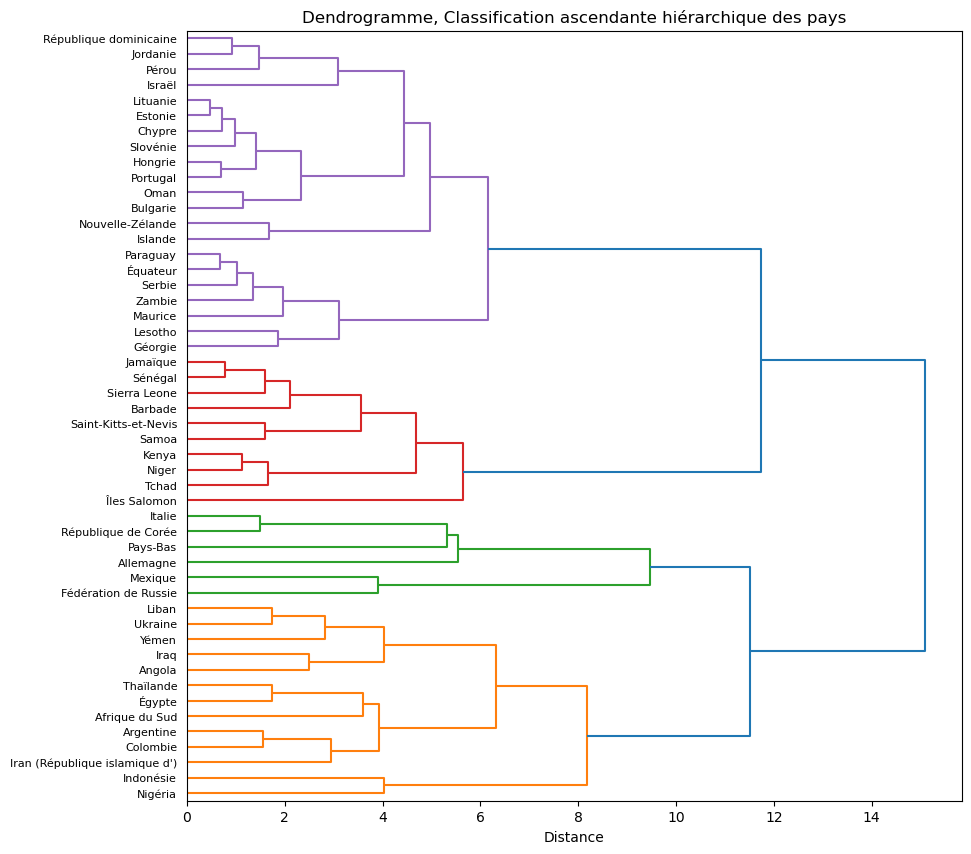

In [296]:
# faire random sample echantillon de 30 pays
# faire plusieurs itération pour valider les clusters
echantillon = df_X_scaled.sample(50)


# mesure les liens entre les clusters avec la méthode de ward
# chaque fois que 2 clusters sont regroupés, cherche à minimiser l'inertie intraclasse

Z = linkage(echantillon, 'ward')


# création du dendogramme
plt.figure(figsize=(10,10))
dendrogram(Z, p=echantillon.shape[0], truncate_mode='lastp', distance_sort='ascending',
           orientation='right', labels=echantillon.index)
plt.title("Dendrogramme, Classification ascendante hiérarchique des pays")
plt.xlabel('Distance')
plt.show();

In [297]:
Z

array([[16.        , 26.        ,  0.47545272,  2.        ],
       [ 0.        , 32.        ,  0.67062118,  2.        ],
       [15.        , 41.        ,  0.70511073,  2.        ],
       [23.        , 50.        ,  0.7242505 ,  3.        ],
       [45.        , 49.        ,  0.77004547,  2.        ],
       [ 1.        ,  3.        ,  0.92171657,  2.        ],
       [11.        , 53.        ,  0.97240199,  4.        ],
       [39.        , 51.        ,  1.01782097,  3.        ],
       [31.        , 33.        ,  1.12775354,  2.        ],
       [ 9.        , 36.        ,  1.14522919,  2.        ],
       [29.        , 57.        ,  1.34682181,  4.        ],
       [52.        , 56.        ,  1.40584443,  6.        ],
       [47.        , 55.        ,  1.46863437,  3.        ],
       [17.        , 25.        ,  1.48761018,  2.        ],
       [37.        , 38.        ,  1.55700255,  2.        ],
       [14.        , 54.        ,  1.58790287,  3.        ],
       [10.        , 24.

On distingue 3 clusters graphiquement et les distances euclidiennes entre les clusters sont plus proches à partir de la 4e valeur d'après le Z (3e colonne).

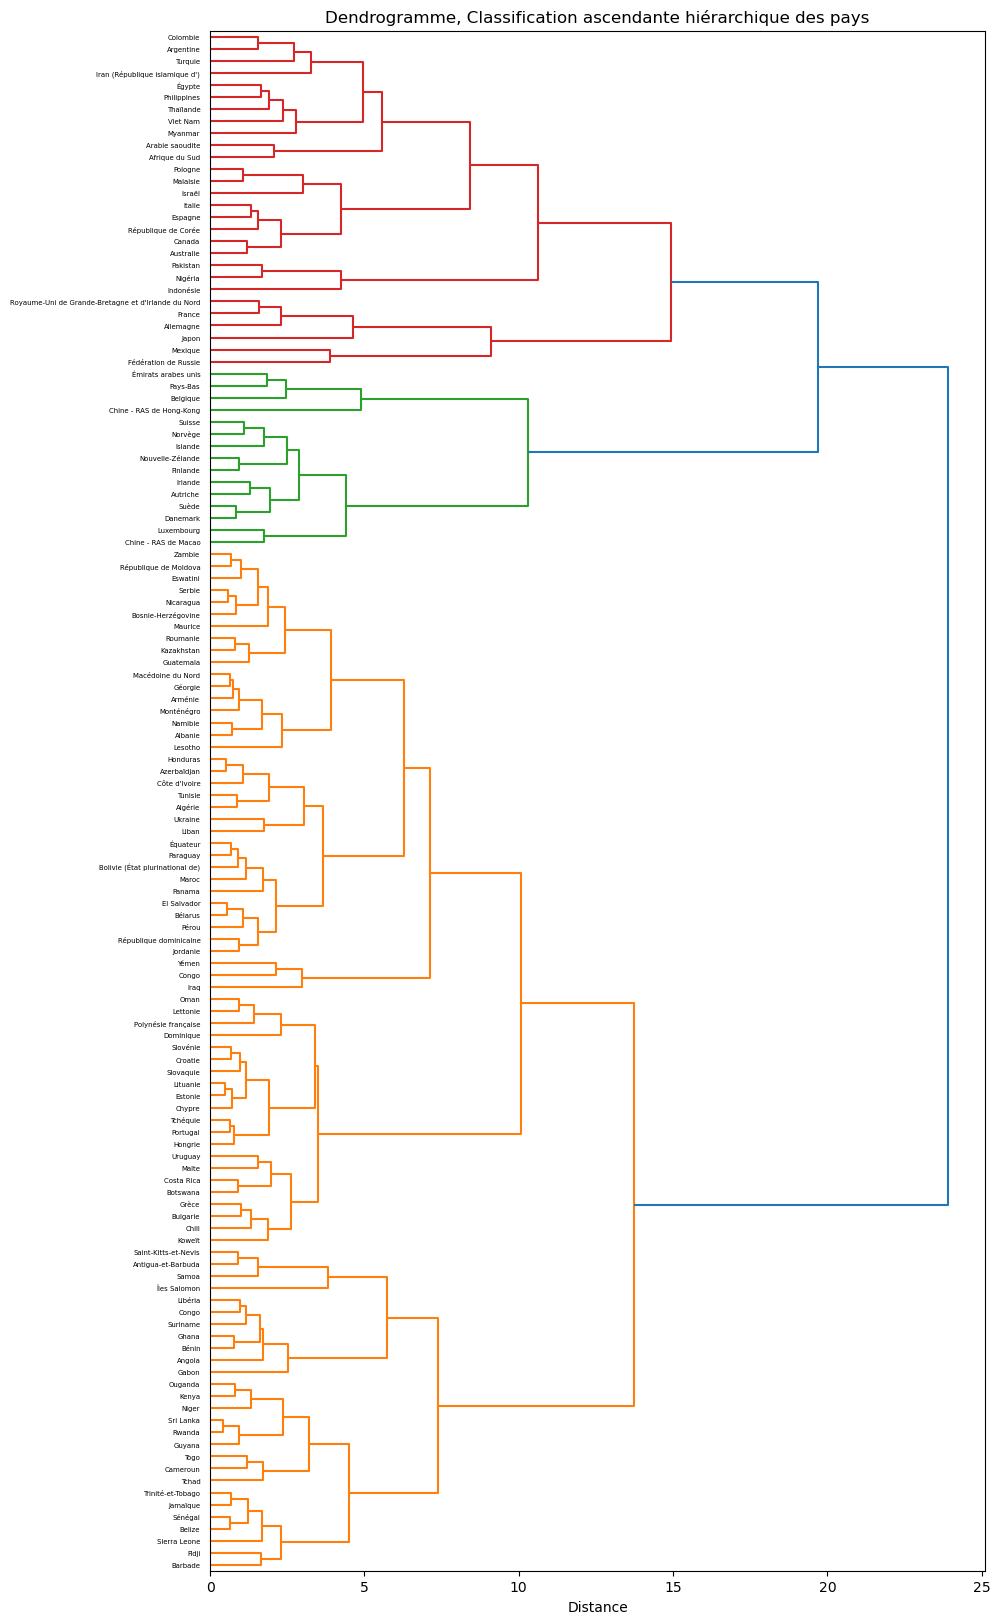

In [298]:
# Dendogramme global

Z = linkage(X_scaled, 'ward')


# création du dendogramme
plt.figure(figsize=(10,20))
dendrogram(Z, p=X_scaled.shape[0], truncate_mode='lastp', distance_sort='ascending',
           orientation='right', labels=pays)
plt.title("Dendrogramme, Classification ascendante hiérarchique des pays")
plt.xlabel('Distance')
plt.show();

In [299]:
Z

array([[ 97.        , 107.        ,   0.40736825,   2.        ],
       [ 37.        ,  68.        ,   0.47545272,   2.        ],
       [ 11.        ,  49.        ,   0.53086279,   2.        ],
       [ 19.        ,  35.        ,   0.53516418,   2.        ],
       [ 79.        , 103.        ,   0.57205673,   2.        ],
       [ 14.        , 111.        ,   0.63237643,   2.        ],
       [ 93.        , 113.        ,   0.64473521,   2.        ],
       [ 48.        ,  70.        ,   0.65817528,   2.        ],
       [ 31.        , 106.        ,   0.66649361,   2.        ],
       [ 88.        , 126.        ,   0.67062118,   2.        ],
       [ 58.        , 116.        ,   0.68198731,   2.        ],
       [ 99.        , 123.        ,   0.68277587,   2.        ],
       [  1.        ,  78.        ,   0.69388402,   2.        ],
       [ 26.        , 129.        ,   0.7242505 ,   3.        ],
       [  8.        , 135.        ,   0.75237395,   3.        ],
       [ 50.        , 134

3 clusters est une bonne solution ici. 5 pourrait convenir aussi.

In [300]:
# création de la classification
cah = AgglomerativeClustering(n_clusters=3, linkage='ward')

cah = cah.fit(X_scaled)

In [301]:
# création des clusters
clusters_cah = cah.labels_

df['clusters_cah'] = clusters_cah

La classification hiérarchique fait ressortir 3 ou 5 clusters. On divisera l'échantillon en 3 clusters pour cette itération.

## Kmeans

### Méthode du coude avec standardisation

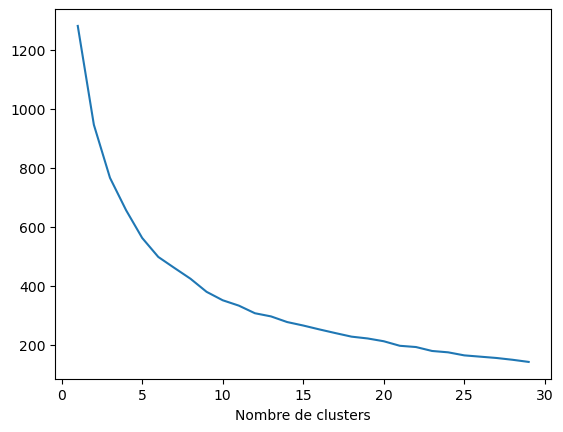

In [302]:
# méthode du coude pour déterminer le nombre de clusters le plus pertinents
# on standardise les données au préalable

liste_clusters = []

for n in range(1,30):
    kmeans = KMeans(n_clusters=n, random_state=1)
    kmeans.fit(X_scaled)
    liste_clusters.append(kmeans.inertia_)

plt.plot(range(1,30), liste_clusters)
plt.xlabel('Nombre de clusters');

Pas vraiment de coude visible, on distingue de légères cassures à 3 et 5 clusters.

### Mesure de qualité des clusters : Silhouette score et Davies Bouldin score

Le **silhouette score** mesure si les individus sont bien regroupés à l'intérieur de leur clusters tout en étant suffisamment séparés des autres clusters. Il varie entre -1 et 1.

- Un score de silhouette proche de 1 indique que l'individu est bien placé dans son propre cluster et qu'il est loin des individus des autres clusters.
- Un score de silhouette proche de 0 indique que l'individu est proche de la frontière entre deux clusters.
- Un score de silhouette proche de -1 indique que l'individu est probablement mal placé et qu'il serait mieux dans un autre cluster.
    
    
Le **Davies-Bouldin score** mesure l'homégénéité du cluster (variance intraclasse) et la séparation entre clusters (variance interclasse). On cherche à avoir une homogénéité faible et une séparation élevé.  
Le **Davies-Bouldin score** doit être minimum pour un bon clustering.

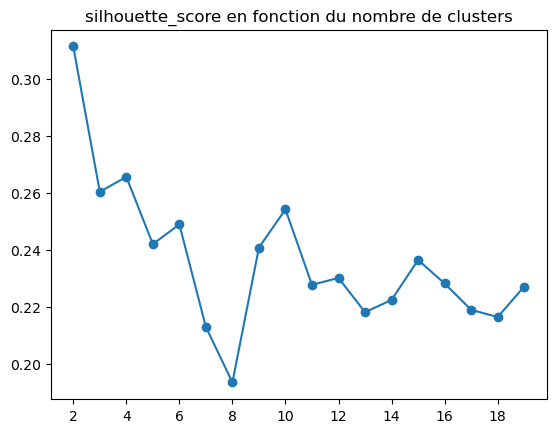

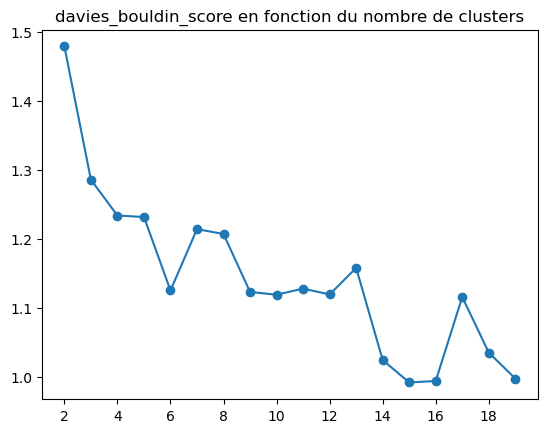

In [303]:
silhouette = []
davies = []

for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(X_scaled)
    clusters_kmeans = kmeans.labels_
    silhouette.append(silhouette_score(X_scaled, clusters_kmeans))
    davies.append(davies_bouldin_score(X_scaled, clusters_kmeans))
    
plt.plot(range(2,20), silhouette, marker='o')
plt.title('silhouette_score en fonction du nombre de clusters')
plt.xticks(np.arange(2, 20, 2))
plt.show()

plt.plot(range(2,20), davies, marker='o')
plt.title('davies_bouldin_score en fonction du nombre de clusters')
plt.xticks(np.arange(2, 20, 2))
plt.show()

Ces 2 graphiques indiqueraient plutôt 6 clusters comme une bonne solution (maximum local pour le silhouette score et minimum local pour le davies bouldin score).  

Pour 3 clusters, le silouhette atteint sa 2e meilleur valeur tandis que le davies bouldin score atteint sa 2e pire valeur si le but est d'être minimiser. Cependant, comme on l'a vu lors de la première itération les points sont tous assez resserés et la frontière entre les clusters n'est pas net.

#### Réalisation KMeans

In [304]:
# création de l'estimateur

kmeans = KMeans(n_clusters=3, random_state=1)

kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=1)

In [305]:
# coordonnées des centroides

centroides = kmeans.cluster_centers_

In [306]:
# clusters de l'echantillon

clusters_kmeans = kmeans.labels_
df['clusters_kmeans']=clusters_kmeans

## ACP (ou PCA), Analyse en composantes principales

L'analyse en composantes principales est une technique de réduction de dimensions.  

L'objectif est de trouver 3 variables (les composantes principales) qui résument au mieux l'ensemble de nos variables de départ.
Chaque composantes principales est une combinaison linéaire des variables de départ et idéalement, elles résument chacunes une partie des variables de départ indépendamment.

L'ACP va permettre de visualiser les données dans un espace à 2 ou 3 dimensions, à grouper nos variables et à identifier les similarités et les disparités entre individus.

### Evaluation de la qualité de la PCA

On va mesurer l'utilité et la qualité de l'analyse en composantes principales grâce au KMO.

Le KMO indique si les variables sont assez corrélées pour faire une ACP. Plus le score est élevé, plus l'ACP est pertinente.

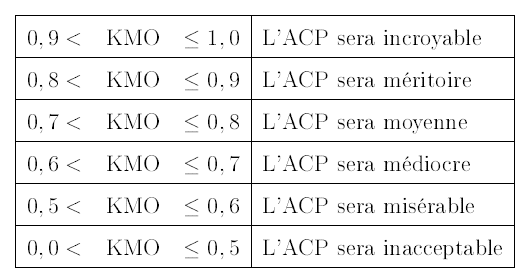

In [307]:
X

,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
0,"6,690.94","514,000.00",0.24,3.57,"381,448,814,653.46",-0.28,0.66,"2,035,000.00",4.44,"57,009,756.00"
1,"4,514.19","38,000.00",0.81,2.56,"13,019,689,336.69",0.38,0.60,"47,000.00",1.43,"2,884,169.00"
2,"4,109.70","2,000.00",0.01,2.52,"170,097,014,589.13",-0.92,0.72,"264,000.00",9.28,"41,389,189.00"
3,"44,651.83","842,000.00",0.48,4.13,"3,690,849,152,517.65",0.59,0.77,"1,609,000.00",1.81,"82,658,409.00"
4,"2,313.22","277,000.00",0.87,2.24,"68,972,769,395.63",-0.33,0.65,"315,000.00",8.52,"29,816,766.00"
5,"15,383.42","7,000.00",1.00,2.90,"1,467,977,777.78",0.75,0.26,"5,000.00",12.48,"95,426.00"
6,"20,802.46","722,000.00",0.50,3.19,"688,586,094,412.68",-0.58,0.83,"1,435,000.00",4.03,"33,101,179.00"
7,"14,648.85","8,000.00",0.00,2.96,"643,628,665,302.15",0.17,0.92,"1,856,000.00",6.81,"43,937,140.00"
8,"3,914.53","35,000.00",0.74,2.51,"11,527,458,565.73",-0.62,0.63,"47,000.00",2.74,"2,944,791.00"
9,"53,957.16","16,000.00",0.01,3.77,"1,326,516,328,531.56",0.89,0.85,"1,171,000.00",1.49,"24,584,620.00"


In [308]:
calculate_kmo(X)

(array([0.75851384, 0.60267204, 0.40784423, 0.76538185, 0.74019691,
        0.77282918, 0.84512158, 0.71338751, 0.7695126 , 0.65221847]),
 0.7120171801905126)

Grâce à la sélection des variables le KMO est acceptable immédiatement.

#### KMO par variable

In [309]:
kmo_variable = pd.DataFrame(data=calculate_kmo(X)[0], index=X.columns.values, columns=['KMO'])
kmo_variable.sort_values('KMO', ascending = False)

,KMO
taux_population_urbaine,0.85
stabilite_politique,0.77
taux_droit_douane,0.77
lpi,0.77
pib_par_habitant,0.76
pib,0.74
volaille_consommée,0.71
population,0.65
importation_volaille,0.60
taux_dependance,0.41


#### Test de sphéricité de Bartlett
Teste l'hypothèse selon laquelle votre matrice de corrélation est une matrice d'identité, ce qui indiquerait que les variables ne sont pas liées et donc ne conviennent pas pour la détection de structure. Des valeurs faibles (inférieures à 0,05) du niveau de signification indiquent qu'une analyse factorielle peut être utile avec vos données.

In [310]:
from factor_analyzer import calculate_bartlett_sphericity

In [311]:
calculate_bartlett_sphericity(X)

(726.5715244412944, 3.928442052642744e-124)

La p-value est inférieur à 0.05, les test est significatif, l'ACP peut être utile aux données.

### PCA

In [312]:
# création de l'estimateur
pca = PCA(n_components=3, random_state=1)

pca.fit(X_scaled)

PCA(n_components=3, random_state=1)

In [313]:
X_scaled.shape

(128, 10)

#### Graphique éboulie des valeurs propres, variance expliquée par chaque composante

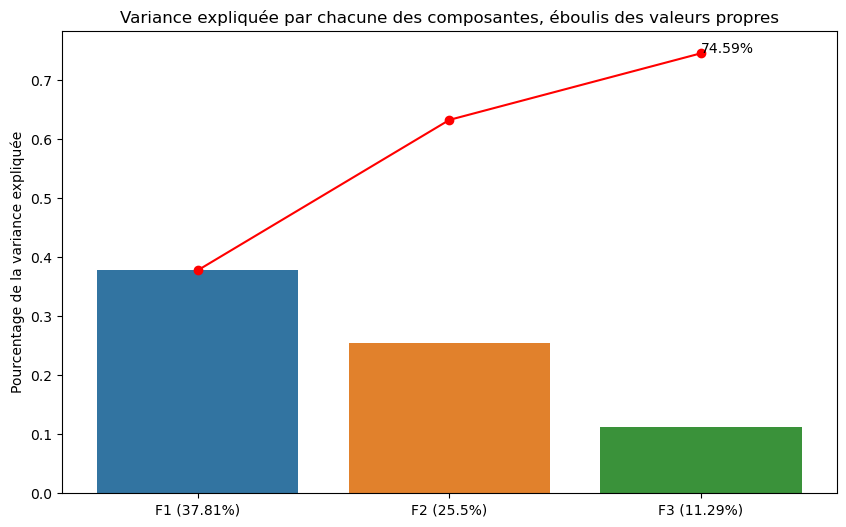

In [314]:
# explication de la variance dans chacune des composantes, éboulis des valeurs propres

cumsum_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize = (10,6))

sns.barplot(x=[n for n in range(pca.components_.shape[0])],
            y=pca.explained_variance_ratio_)

plt.plot([n for n in range(pca.components_.shape[0])], cumsum_variance, c='r', marker='o')


listF = []
for x in range(pca.components_.shape[0]):
    a = f"F{x+1} ({round(100*pca.explained_variance_ratio_[x],2)}%)"
    listF.append(a)
    
plt.text(max([n for n in range(pca.components_.shape[0])]), cumsum_variance.max(), '{:.2%}'.format(round(cumsum_variance.max(),4)))  
plt.title("Variance expliquée par chacune des composantes, éboulis des valeurs propres")
plt.ylabel("Pourcentage de la variance expliquée")
plt.xticks([n for n in range(pca.components_.shape[0])], listF);

74% de la variance est expliquée par les 3 composantes principales, l'ACP est bonne, elle représente les 3/4 de l'information.

#### Représentation des composantes dans les variables

On cherche à déterminer l'idée principale de chaque composante principale en analysant les combinaisons linéaires de chaque chaque composante.  
On associe chaque variable à la composante par laquelle elle est le plus représentée, on groupe les variables puis en essaie de tirer une idée générale de chaque composante.

Le cercle des corrélations assurera aussi cette fonction.

In [315]:
df_composante = pd.DataFrame(data=pca.components_, index=['F1', 'F2', 'F3'], columns=variables).T
df_composante

,F1,F2,F3
pib_par_habitant,0.38,-0.27,-0.10
importation_volaille,0.35,0.22,0.50
taux_dependance,0.11,-0.28,0.74
lpi,0.46,-0.11,-0.12
pib,0.37,0.30,0.08
stabilite_politique,0.25,-0.40,-0.06
taux_population_urbaine,0.37,-0.12,-0.11
volaille_consommée,0.24,0.49,-0.02
taux_droit_douane,-0.32,0.11,0.39
population,0.11,0.53,-0.06


#### Identification d'une composante principale associée à chaque variable

In [316]:
# on copie df_composante et on sort les variables
df_composante2 = df_composante.reset_index()
df_composante2.rename(columns={'index':'variable'}, inplace=True)

In [317]:
# on pivote les 3 composantes sur une colonne
melt = pd.melt(df_composante2, id_vars='variable', value_vars=['F1','F2','F3'], var_name = 'composantes',
        value_name='correlation')

In [318]:
# valeur absolu correlation
melt['correlation_abs'] = melt['correlation'].abs()

# window function pour avoir le rang de chaque composante
melt['rank'] = melt.groupby(['variable'])['correlation_abs'].rank(ascending=False)

In [319]:
composante_variable = melt[melt['rank']==1][['variable', 'composantes', 'correlation']].reset_index(drop=True)
composante_variable

,variable,composantes,correlation
0,pib_par_habitant,F1,0.38
1,lpi,F1,0.46
2,pib,F1,0.37
3,taux_population_urbaine,F1,0.37
4,stabilite_politique,F2,-0.40
5,volaille_consommée,F2,0.49
6,population,F2,0.53
7,importation_volaille,F3,0.50
8,taux_dependance,F3,0.74
9,taux_droit_douane,F3,0.39


#### Analyse du sens des composantes principales

F1 : 
- Pib, Pib par habitant, lpi, taux de population urbaine + stabilité politique plutôt fort aussi
- On peut la synthétiser par **Développement, Richesse et Qualité de vie**

F2 : 
- Quantité de volaille consommée, population (et instabilité politique)
- On peut la synthétiser par **Taille du Pays et du Marché**

F3 : 
- Quantité de volaille importée, taux de dépendance et taux de droit de douane
- On peut la synthétiser par **Besoin en Volaille**

In [320]:
# En résumé
F1_resume = "Développement, Richesse et Qualité de vie"
F2_resume = "Taille du Pays et du Marché"
F3_resume = "Besoin en Volaille"

resume_composante = [F1_resume, F2_resume, F3_resume]

## Analyse Résultats

### Cercle de corrélation et Représentation des individus sur le plan factoriel

In [321]:
# représenation des individus sur le plan factoriel
X_projected = pca.transform(X_scaled)

df_projection = pd.DataFrame(data=X_projected, columns=['F1', 'F2', 'F3'], index=pays)
df_projection

,F1,F2,F3
Afrique du Sud,1.61,2.06,0.49
Albanie,-0.66,-1.00,0.21
Algérie,-1.44,0.86,-0.34
Allemagne,5.77,2.60,1.33
Angola,-1.04,0.33,1.62
Antigua-et-Barbuda,-1.54,-1.09,1.49
Arabie saoudite,2.11,1.49,1.38
Argentine,0.79,1.23,-0.89
Arménie,-1.07,-0.48,0.30
Australie,2.83,-0.26,-1.61


Tous les individus ont été transformés sur le plan factoriel. Ils ont été réduit selon leurs composantes principales.

In [322]:
def correlation_graph(pca, 
                      x_y, 
                      features,
                      resume_composante) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(15, 13))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    axe_x = 'F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1))
    axe_y = 'F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1))
    plt.xlabel(f"{axe_x} : {resume_composante[x]}")
    plt.ylabel(f"{axe_y} : {resume_composante[y]}")

    # # Affichage du titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [323]:
def display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=None,
                                labels = None,
                                clusters=None,
                                centroides=None,
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1} : {resume_composante[x]}')
    ax.set_ylabel(f'F{y+1} {v2} : {resume_composante[y]}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')
    
    # On vérifie s'il y a des centroides ou non
    if centroides is None : 
        centroides = []
    if len(centroides) :   
    # visualisation des centroides sous forme de croix rouge
        plt.scatter(centroides[:,x], centroides[:,y], c='r', marker='x', s=100)

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

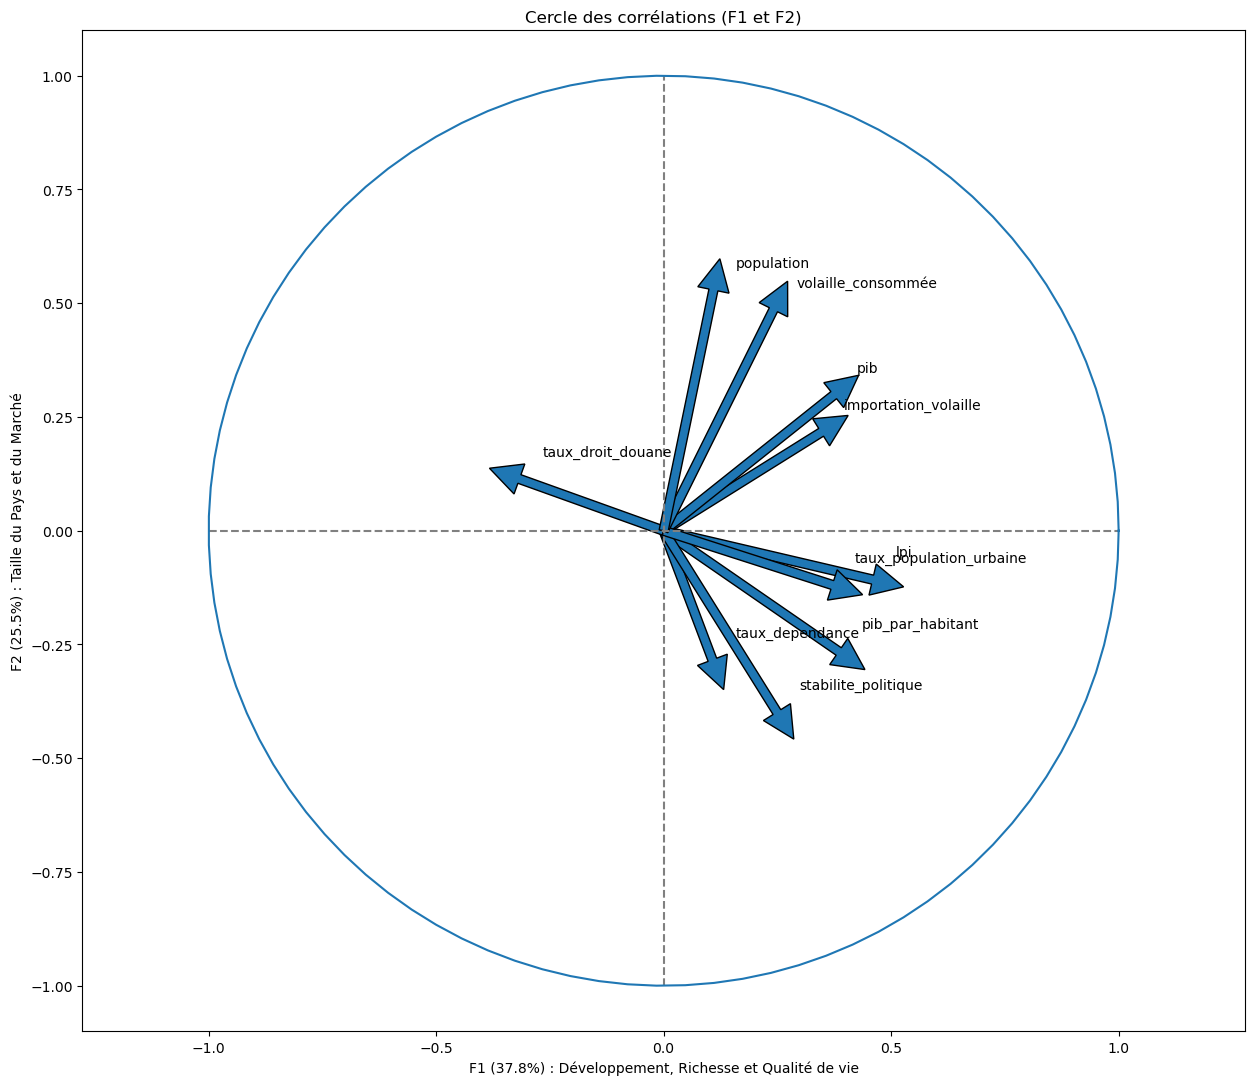

In [324]:
# Plan factoriel composé de F1 et F2
# affichage des variables sur ce plan factoriel
# affichage du cercle des corrélations

x_y = (0,1)
features = variables
correlation_graph(pca, x_y, features, resume_composante)

La moitié supérieur concerne les variables plutôt associées à la Taille du Pays et du Marché (F2). Avec notamment la population et la quantité de volaille consommée.  
La partie droite concerne les variables plutôt associées au Développement, à la Richesse et à la Qualité de vie (F1). Avec notamment le pib par habitant, le lpi et le taux de population urbaine.

La stabilité politique appartient aux 2 groupes, elle est corrélée aux variables de "Développement, à la Richesse et à la Qualité de vie" et inversement corrélée aux variables de "Taille du Pays et du Marché" à cause de grands pays qui ont une stabilité politique plus faible (Russie, Mexique, Pakistan, Indonésie, Nigéria, Iran...).

Sur ce plan factoriel, on cherchera plutôt des pays positionnés entre les 2 groupes de variables, des pays développés importateurs de volailles.

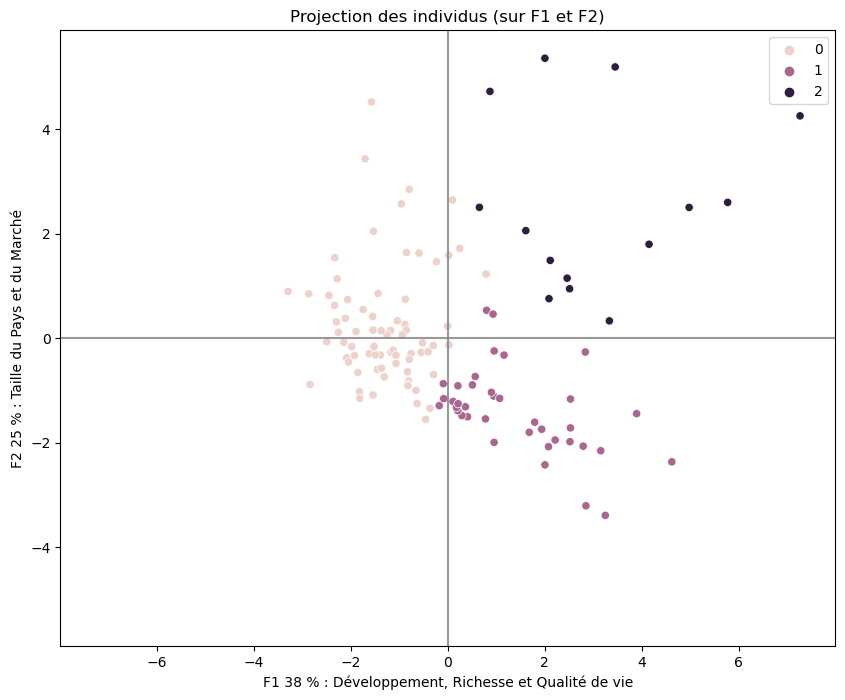

In [325]:
x_y = (0,1)

display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=pca,
                                labels = None,
                                clusters=clusters_kmeans,
                                centroides=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." )

Sur ce plan factoriel : 

- Le clusters 0 représentent les pays avec un indice F1 faible à moyen et un indice F2 faible à fort.  
On peut l'associer au pays 'pauvres', 'peu développés', 'en développement', 'qualité de vie faible'.

- Le clusters 1 représentent les pays avec un indice F1 moyen à fort et un indice F2 moyen à faible.  
On peut l'associer au pays 'riches', 'développés', 'petits à moyens pays', 'qualité de vie élevé'.

- Le clusters 2 représentent les pays avec un indice F1 moyen à fort et un indice F2 moyen à fort.  
On peut l'associer au pays 'puissants', 'développés', 'grands pays', 'qualité de vie plus ou moins élevé'.

On cherchera des pays avec F1>0 et F2>-2 dans un premier temps.

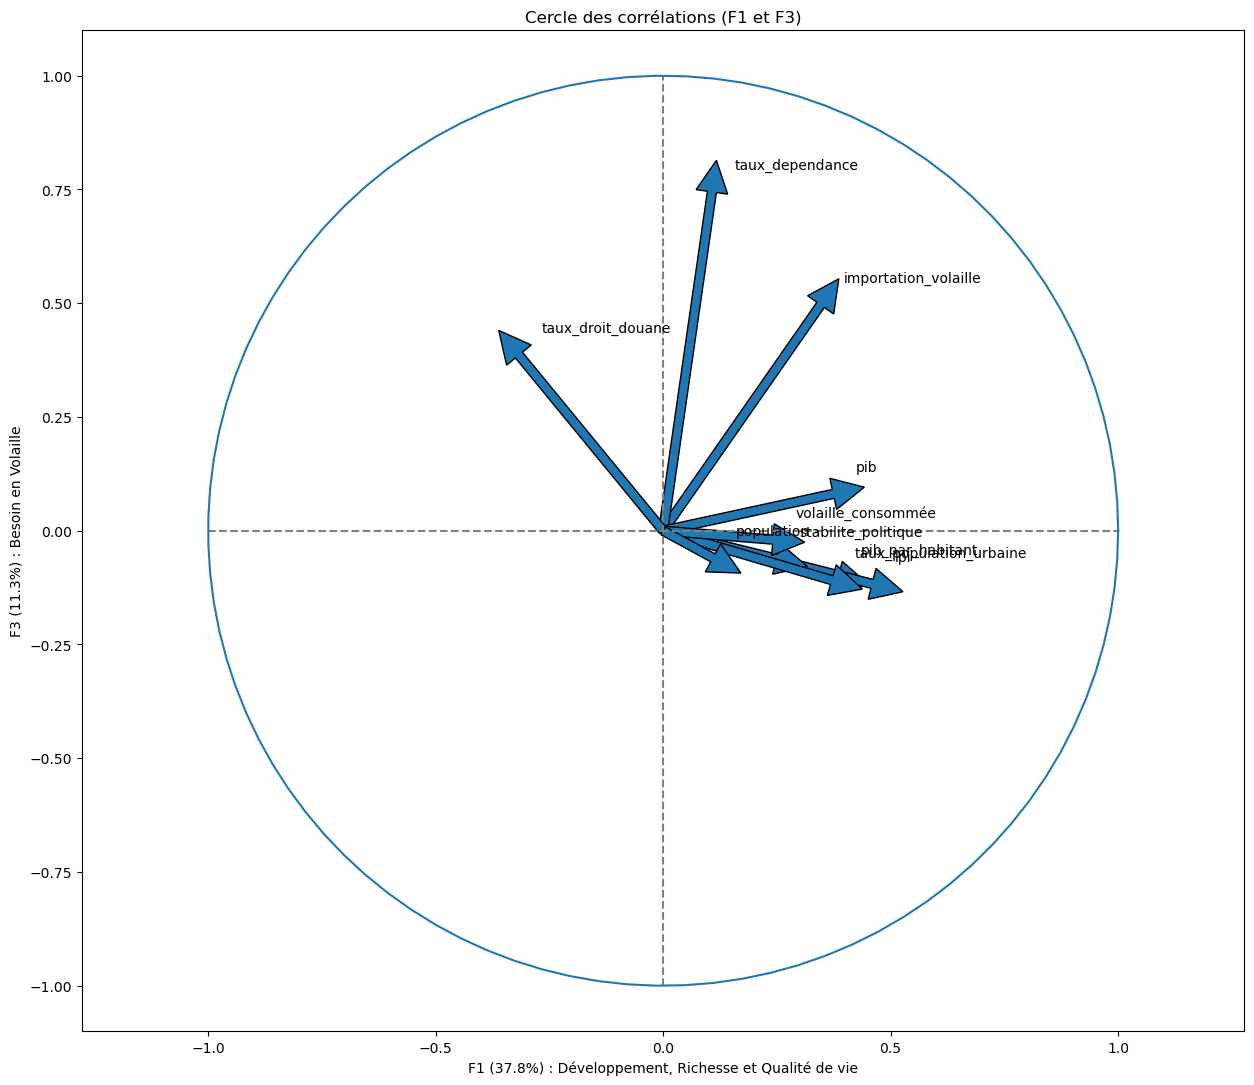

In [326]:
# Cercle des corrélation sur F1 et F3

x_y = (0,2)
correlation_graph(pca, x_y, features, resume_composante)

La moitié supérieur concerne les variables associées au 'Besoin en Volaille' (F3).  
La partie droite concerne les variables plutôt associées au Développement, à la Richesse et à la Qualité de vie (F1).

Sur ce plan factoriel, on cherchera des pays positionnés dans le quart supérieur droit, ce qui permettra de visualiser les pays qui ont un fort besoin en volaille, qui sont développés et qui ont un taux de douane acceptable.

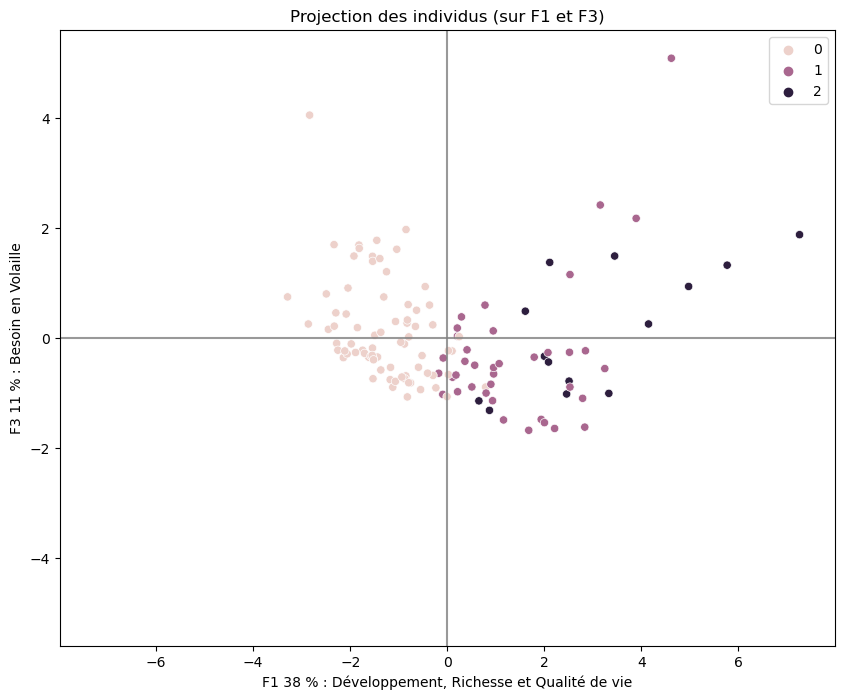

In [327]:
x_y = (0,2)

display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=pca, 
                                labels = None,
                                clusters=clusters_kmeans, 
                                centroides=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." )

Sur ce plan factoriel : 

- Le clusters 0 représentent les pays avec un indice F1 faible à moyen et un indice F3 faible à fort.  
On peut l'associer au pays 'peu développés', avec 'qualité de vie faible', avec 'besoin en volaille plus ou moins importants'.

- Les clusters 1  et 2 sont confondus, ils représentent des pays avec un indice F1 moyen à fort et F2 faible à fort :  
Ils décrivent tous les 2 des pays 'développés' avec un besoin plus ou moins fort en volaille.  
Sachant que le besoin en volaille dépend aussi de la taille du pays.

On cherchera ici plutôt des pays avec F1>0 et F3>-1

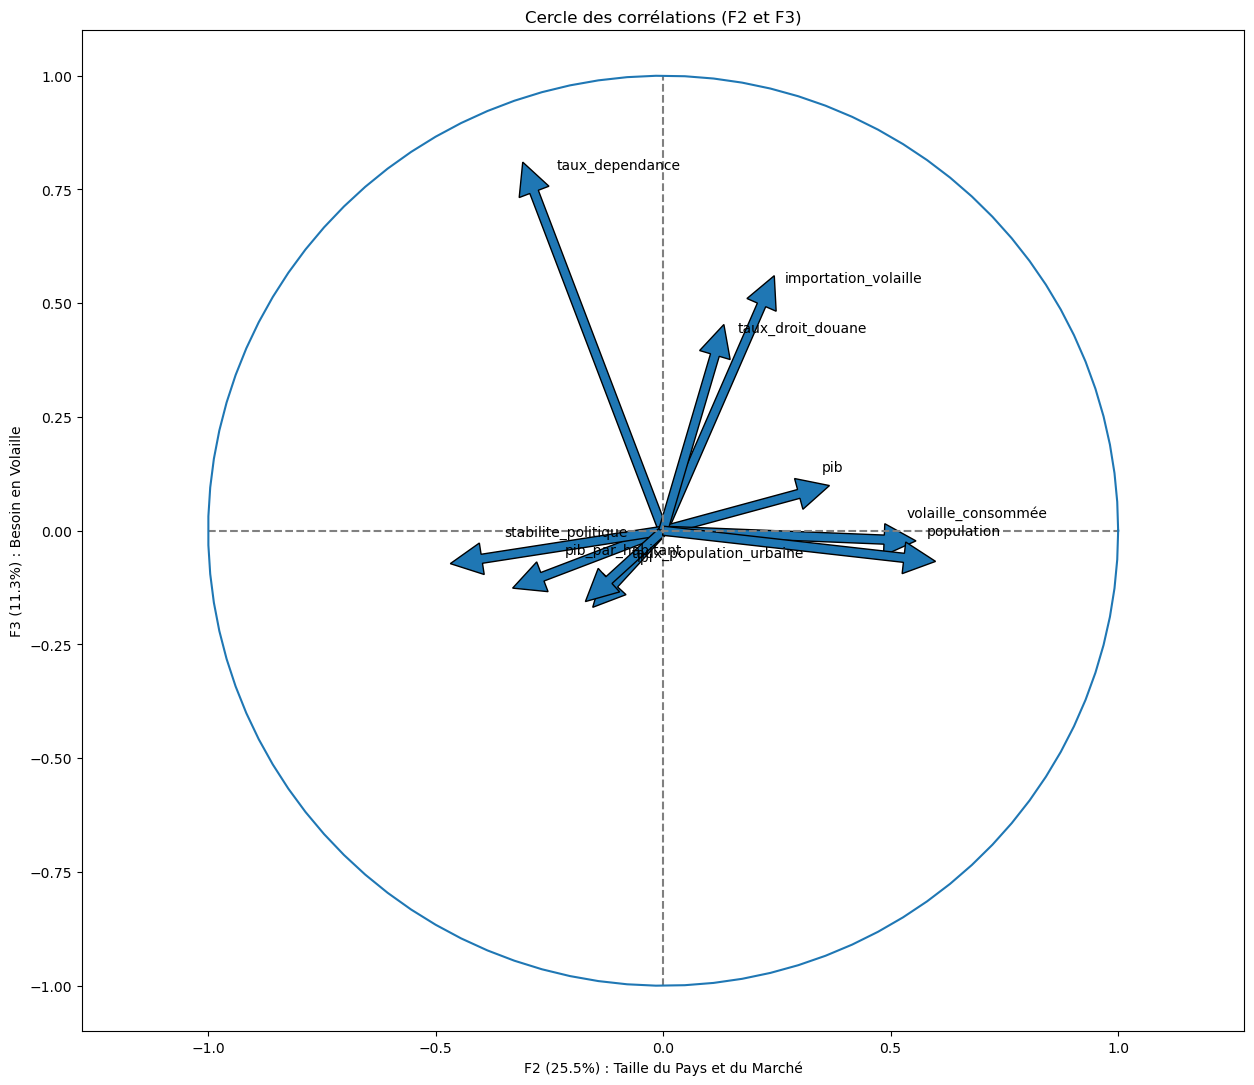

In [328]:
# Cercle des corrélation sur F2 et F3

x_y = (1,2)
correlation_graph(pca, x_y, features, resume_composante)

Sur ce plan factoriel :  
La moitié supérieur concerne les variables associées au besoin en volaille avec à gauche le taux de dépendance qui ne prend pas en compte la taille du pays et à droite la quantité d'importation de volaille (en tonnes) qui prend en compte la taille d pays et la population.  
Les parties gauche et droite concernent les variables associées à la taille du pays et du marché.

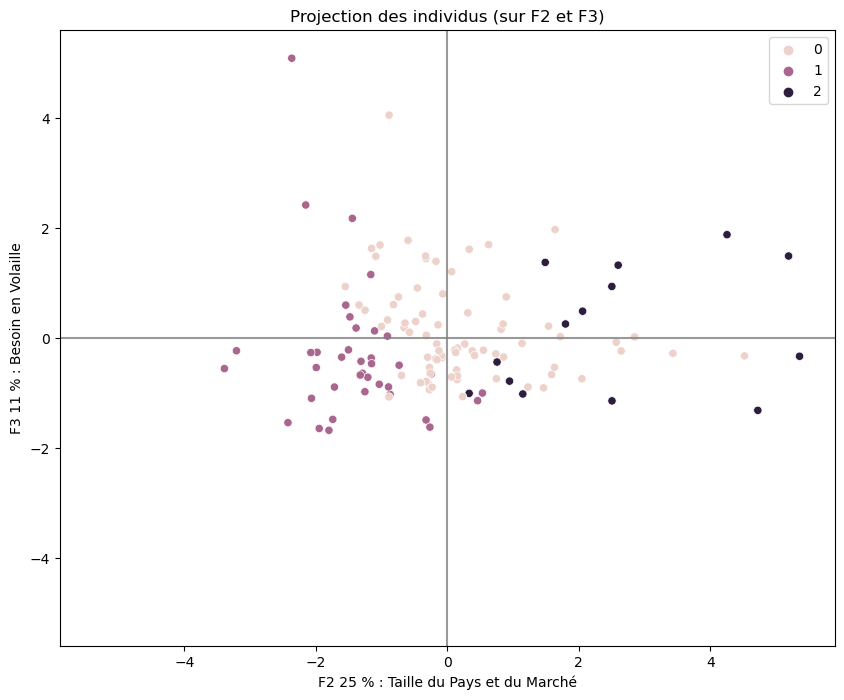

In [329]:
x_y = (1,2)

display_factorial_planes(   X_projected, 
                                x_y,
                                resume_composante,
                                pca=pca, 
                                labels = None,
                                clusters=clusters_kmeans, 
                                centroides=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." )

Sur ce plan factoriel : 

- Le clusters 0 représentent les pays avec un indice F2 faible à fort et un indice F3 faible à fort.  

- Le clusters 1 représentent les pays avec un indice F2 faible à moyen et un indice F3 faible à fort.  

- Le clusters 2 représentent les pays avec un indice F2 moyen à fort et un indice F3 faible à fort.  

C'est surtout F3 qui est important ici (F3 >0).

### Qualité de représentation des individus

Certains individus sont plus ou moins bien représentés sur le plan factoriel.  
On va voir ici comment mesure cette qualité de représentation.

Pour calculer la qualité de représentation des individus sur les axes, on calcule les carrés des distances à l’origine des individus, qui correspondent également à leur contribution dans l’inertie totale.

Voici la formule :

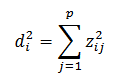

#### Di²

In [330]:
di2 = np.sum(X_scaled**2,axis=1)

df_di2 = pd.DataFrame({'di2':di2}, index=pays)
df_di2.sort_values('di2', ascending=False).head(20)

,di2
Japon,86.17
Chine - RAS de Hong-Kong,58.98
Mexique,49.34
Allemagne,48.47
Fédération de Russie,42.32
Indonésie,39.32
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,34.20
Îles Salomon,32.52
Pakistan,31.84
Luxembourg,30.74


Cela semble correspondre aux outliers également.

#### Cos²

Ensuite nous devons calculer le cos² de chaque individu pour chaque composante. Il représente la qualité de représentation par rapport à cette composante.

Ensuite on ajoutera les cos² des 2 composantes principales pour chaque plan factoriel.
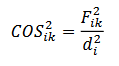

In [331]:
# multiplication de tous les termes par eux même
cos2 = df_projection**2

# application de la formule ci-dessus
for j in range(cos2.columns.shape[0]):    
    cos2.iloc[:,j] = cos2.iloc[:,j]/di2
    
cos2.columns = ['cos2_1', 'cos2_2', 'cos2_3']

cos2['total'] = cos2.sum(axis=1)
cos2.sort_values('total', ascending=False)

,cos2_1,cos2_2,cos2_3,total
Pays-Bas,0.66,0.09,0.21,0.96
Libéria,0.59,0.02,0.35,0.95
Espagne,0.76,0.11,0.07,0.94
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,0.72,0.18,0.03,0.93
Nouvelle-Zélande,0.29,0.34,0.29,0.92
Suède,0.58,0.27,0.07,0.92
Finlande,0.38,0.31,0.22,0.91
Danemark,0.56,0.35,0.01,0.91
Émirats arabes unis,0.64,0.14,0.13,0.91
France,0.76,0.14,0.00,0.90


On utilisera ce tableau pour vérifier que les pays sélectionnés pour le nouveau marché sont bien représentés sur le plan factoriel.

### Représentation des centroides de chaque clusters et synthèse des clusters

In [332]:
df_centroide_kmeans = pd.DataFrame(pca.transform(centroides), columns=['F1', 'F2', 'F3'])
df_centroide_kmeans

,F1,F2,F3
0,-1.28,0.23,0.13
1,1.42,-1.40,-0.31
2,3.09,2.55,0.13


In [389]:
def projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca) :

    fig, ax = plt.subplots(1, 1, figsize=[7,5])

    x,y = x_y

    markers = ['o', 's', '^', 'v', '+', 'x', '*', 'D', '.', ',', '1', '2', '3', '4', 'p']

    X = df_centroide_kmeans.values

    # Valeur x max et y max
    x_max = np.abs(X[:, x]).max() *1.5
    y_max = np.abs(X[:, y]).max() *1.5

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # titre
    plt.title(f"Centroides sur le plan factoriel {df_centroide_kmeans.columns[x]}/{df_centroide_kmeans.columns[y]}")


    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1} : {resume_composante[x]}')
    ax.set_ylabel(f'F{y+1} {v2} : {resume_composante[y]}')

    # point centroides
    for i in range(len(X)):
        plt.scatter(X[i,x], X[i,y], marker=markers[i], label=f'Clusters {range(len(X))[i]}')
    
    # affichage legend
    plt.legend()

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

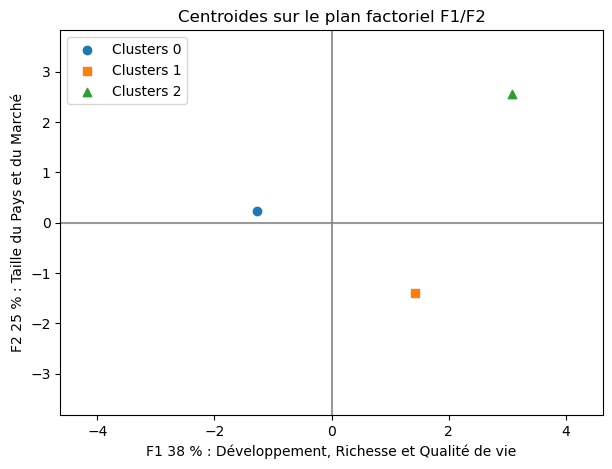

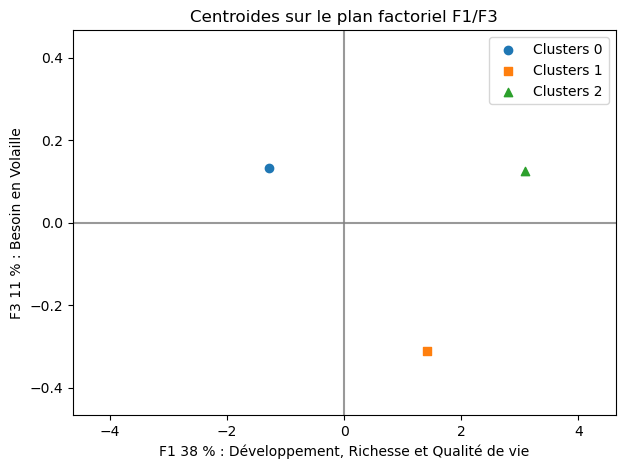

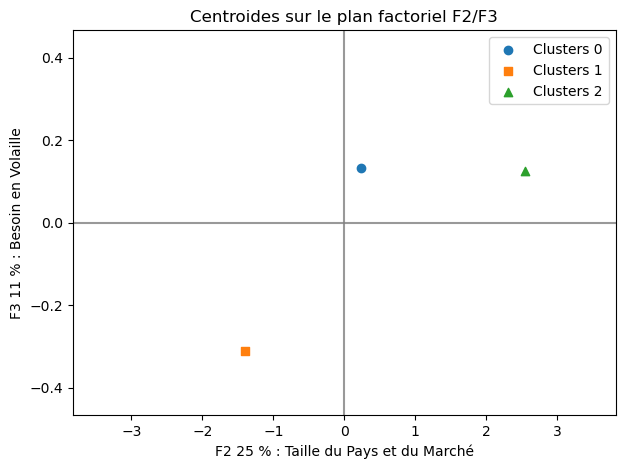

In [334]:
x_y = (0,1)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

x_y = (0,2)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

x_y = (1,2)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

Cluster 0 :  
Développement, Richesse et Qualité de vie -  
Taille du Pays et du Marché - +  
Besoin en Volaille +  


Cluster 1 :  
Développement, Richesse et Qualité de vie +  
Taille du Pays et du Marché -  
Besoin en Volaille -  


Cluster 2 :  
Développement, Richesse et Qualité de vie +  
Taille du Pays et du Marché +  
Besoin en Volaille +    

D'après ces constats, il semblerait que se soit le clusters 2 qui soit le plus intéressant.  
Mais les clusters étant resserés, les points en bordure de clusters peuvent aussi être intéressant notamment certains pays du clusters 1.

### Représentation 3D

In [335]:
title = "Représentation des pays en fonction des 3 composantes principales"

fig = px.scatter_3d(x=X_projected[:,0], y=X_projected[:,1], z=X_projected[:, 2], hover_name=pays,
              color=clusters_kmeans, title=title, labels={'x':'F1', 'y':'F2', 'z':'F3'})
fig.show()

### Visualisation des clusters sur la carte

In [336]:
# importation latitude et longitude
coordonnees = pd.read_csv(folder+'latitude_longitude.csv', sep=';')
coordonnees.columns = ['pays', 'latitude', 'longitude', 'clusters']

In [337]:
coordonnees = coordonnees[['pays', 'latitude', 'longitude']]

In [338]:
# df avec les coordonnées gps
df_carte = df.merge(coordonnees, how='left', on='pays')
df_carte.head()

,pays,exportation_volaille,importation_volaille,production,volaille_consommée,taux_dependance,taux_autosuffisance,proportion_volaille_nourriture,proportion_animaux_nourriture,population,...,taux_droit_douane,quantite_conteneurs_par_annee,taux_population_urbaine,stabilite_politique,pib_par_habitant,classement_consommation,clusters_cah,clusters_kmeans,latitude,longitude
0,Afrique du Sud,"63,000.00","514,000.00","1,667,000.00","2,035,000.00",0.24,0.76,0.06,0.12,"57,009,756.00",...,4.44,"4,563,618.00",0.66,-0.28,"6,690.94",10.00,0,2,"-31,7","23,441"
1,Albanie,0.00,"38,000.00","13,000.00","47,000.00",0.81,0.28,0.01,0.05,"2,884,169.00",...,1.43,"118,270.00",0.60,0.38,"4,514.19",101.50,1,0,"40,654","20,076"
2,Algérie,0.00,"2,000.00","275,000.00","264,000.00",0.01,0.99,0.01,0.03,"41,389,189.00",...,9.28,"1,725,238.00",0.72,-0.92,"4,109.70",51.50,1,0,"28,6045","2,64"
3,Allemagne,"646,000.00","842,000.00","1,514,000.00","1,609,000.00",0.48,0.50,0.02,0.10,"82,658,409.00",...,1.81,"15,169,595.00",0.77,0.59,"44,651.83",15.00,0,2,"51,3819","9,9877"
4,Angola,0.00,"277,000.00","42,000.00","315,000.00",0.87,0.13,0.02,0.07,"29,816,766.00",...,8.52,"570,200.00",0.65,-0.33,"2,313.22",48.50,1,0,"-12,836","17,808"


In [339]:
code_iso_3 = {
    'Afrique du Sud': 'ZAF',
    'Albanie': 'ALB',
    'Algérie': 'DZA',
    'Allemagne': 'DEU',
    'Angola': 'AGO',
    'Antigua-et-Barbuda': 'ATG',
    'Arabie saoudite': 'SAU',
    'Argentine': 'ARG',
    'Arménie': 'ARM',
    'Australie': 'AUS',
    'Autriche': 'AUT',
    'Azerbaïdjan': 'AZE',
    'Barbade': 'BRB',
    'Belgique': 'BEL',
    'Belize': 'BLZ',
    'Bolivie (État plurinational de)': 'BOL',
    'Bosnie-Herzégovine': 'BIH',
    'Botswana': 'BWA',
    'Brésil': 'BRA',
    'Bulgarie': 'BGR',
    'Bélarus': 'BLR',
    'Bénin': 'BEN',
    'Cameroun': 'CMR',
    'Canada': 'CAN',
    'Chili': 'CHL',
    'Chine - RAS de Hong-Kong': 'HKG',
    'Chine - RAS de Macao': 'MAC',
    'Chine, continentale': 'CHN',
    'Chypre': 'CYP',
    'Colombie': 'COL',
    'Congo': 'COG',
    'Costa Rica': 'CRI',
    'Croatie': 'HRV',
    "Côte d'Ivoire": 'CIV',
    'Danemark': 'DNK',
    'Dominique': 'DMA',
    'El Salvador': 'SLV',
    'Espagne': 'ESP',
    'Estonie': 'EST',
    'Eswatini': 'SWZ',
    'Fidji': 'FJI',
    'Finlande': 'FIN',
    'France': 'FRA',
    'Fédération de Russie': 'RUS',
    'Gabon': 'GAB',
    'Ghana': 'GHA',
    'Grèce': 'GRC',
    'Guatemala': 'GTM',
    'Guyana': 'GUY',
    'Géorgie': 'GEO',
    'Honduras': 'HND',
    'Hongrie': 'HUN',
    'Inde': 'IND',
    'Indonésie': 'IDN',
    "Iran (République islamique d')": 'IRN',
    'Iraq': 'IRQ',
    'Irlande': 'IRL',
    'Islande': 'ISL',
    'Israël': 'ISR',
    'Italie': 'ITA',
    'Jamaïque': 'JAM',
    'Japon': 'JPN',
    'Jordanie': 'JOR',
    'Kazakhstan': 'KAZ',
    'Kenya': 'KEN',
    'Koweït': 'KWT',
    'Lesotho': 'LSO',
    'Lettonie': 'LVA',
    'Liban': 'LBN',
    'Libéria': 'LBR',
    'Lituanie': 'LTU',
    'Luxembourg': 'LUX',
    'Macédoine du Nord': 'MKD',
    'Malaisie': 'MYS',
    'Malte': 'MLT',
    'Maroc': 'MAR',
    'Maurice': 'MUS',
    'Mexique': 'MEX',
    'Monténégro': 'MNE',
    'Myanmar': 'MMR',
    'Namibie': 'NAM',
    'Nicaragua': 'NIC',
    'Niger': 'NER',
    'Nigéria': 'NGA',
    'Norvège': 'NOR',
    'Nouvelle-Zélande': 'NZL',
    'Oman': 'OMN',
    'Ouganda': 'UGA',
    'Pakistan': 'PAK',
    'Panama': 'PAN',
    'Paraguay': 'PRY',
    'Pays-Bas': 'NLD',
    'Philippines': 'PHL',
    'Pologne': 'POL',
    'Polynésie française': 'PYF',
    'Portugal': 'PRT',
    'Pérou': 'PER',
    'Roumanie': 'ROU',
    "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord": 'GBR',
    'Rwanda': 'RWA',
    'République de Corée': 'KOR',
    'République de Moldova': 'MDA',
    'République dominicaine': 'DOM',
    'Saint-Kitts-et-Nevis': 'KNA',
    'Samoa': 'WSM',
    'Serbie': 'SRB',
    'Sierra Leone': 'SLE',
    'Slovaquie': 'SVK',
    'Slovénie': 'SVN',
    'Sri Lanka': 'LKA',
    'Suisse': 'CHE',
    'Suriname': 'SUR',
    'Suède': 'SWE',
    'Sénégal': 'SEN',
    'Tchad': 'TCD',
    'Tchéquie': 'CZE',
    'Thaïlande': 'THA',
    'Togo': 'TGO',
    'Trinité-et-Tobago': 'TTO',
    'Tunisie': 'TUN',
    'Turquie': 'TUR',
    'Ukraine': 'UKR',
    'Uruguay': 'URY',
    'Viet Nam': 'VNM',
    'Yémen': 'YEM',
    'Zambie': 'ZMB',
    'Égypte': 'EGY',
    'Émirats arabes unis': 'ARE',
    'Équateur': 'ECU',
    "États-Unis d'Amérique": 'USA',
    'Îles Salomon': 'SLB'
}

In [340]:
# df code iso
code_iso = pd.DataFrame(data=code_iso_3, index=['code_iso']).T.reset_index().rename(columns={'index' : 'pays'})

In [341]:
# jointure df carte
df_carte = df_carte.merge(code_iso, how='left', on='pays')

In [342]:
# création de la carte
fig = px.choropleth(df_carte, color='clusters_kmeans', locations='code_iso',
                    hover_name='pays', title='Carte des clusters', scope='world')
fig.show()

### Analyse des pays par clusters

In [343]:
# df analyse finale
col_finale = np.insert(variables, 0, ['pays', 'clusters_kmeans'])
df_final = df[col_finale]
df_final = df_final.set_index('pays')
df_final.head()

,clusters_kmeans,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
pays,,,,,,,,,,,
Afrique du Sud,2,"6,690.94","514,000.00",0.24,3.57,"381,448,814,653.46",-0.28,0.66,"2,035,000.00",4.44,"57,009,756.00"
Albanie,0,"4,514.19","38,000.00",0.81,2.56,"13,019,689,336.69",0.38,0.60,"47,000.00",1.43,"2,884,169.00"
Algérie,0,"4,109.70","2,000.00",0.01,2.52,"170,097,014,589.13",-0.92,0.72,"264,000.00",9.28,"41,389,189.00"
Allemagne,2,"44,651.83","842,000.00",0.48,4.13,"3,690,849,152,517.65",0.59,0.77,"1,609,000.00",1.81,"82,658,409.00"
Angola,0,"2,313.22","277,000.00",0.87,2.24,"68,972,769,395.63",-0.33,0.65,"315,000.00",8.52,"29,816,766.00"


Distribution des variables pour chaque clusters


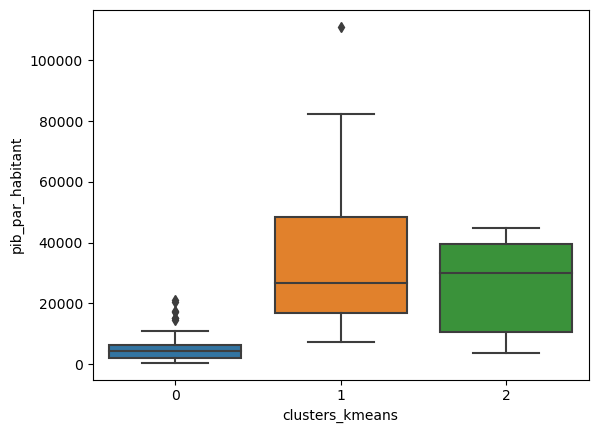

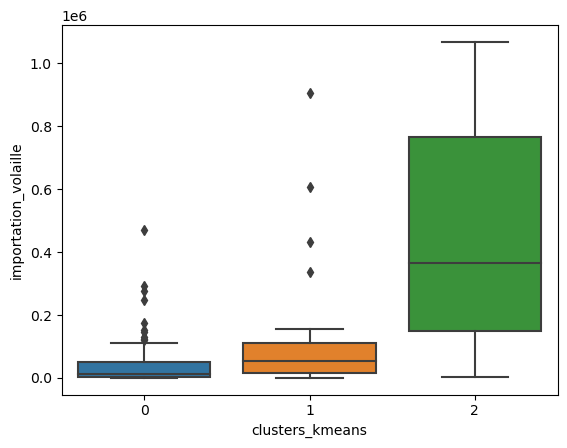

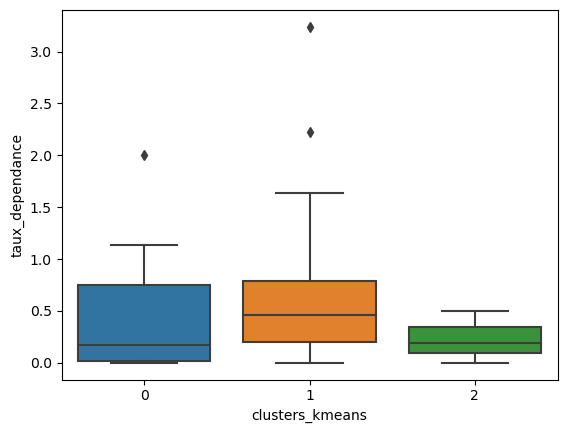

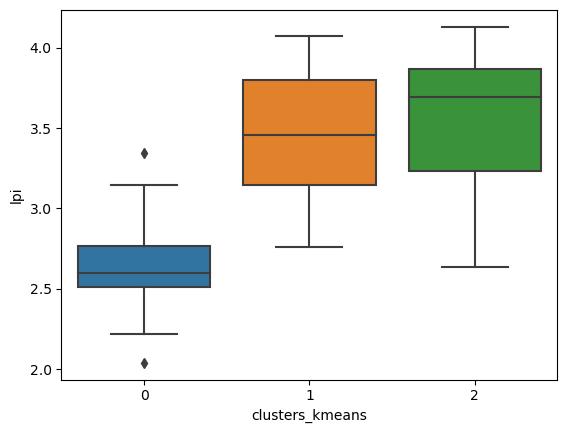

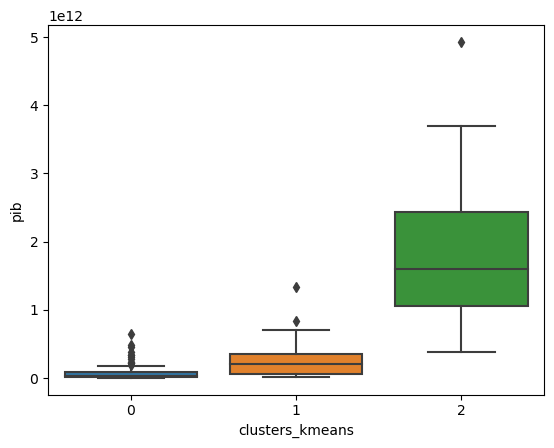

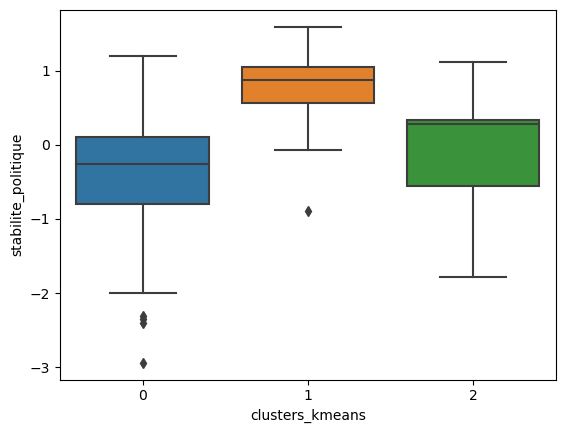

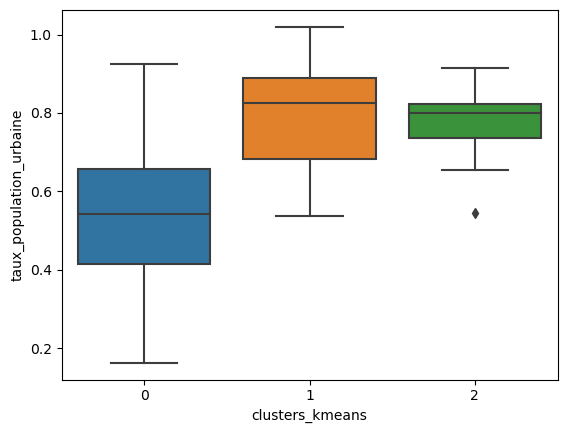

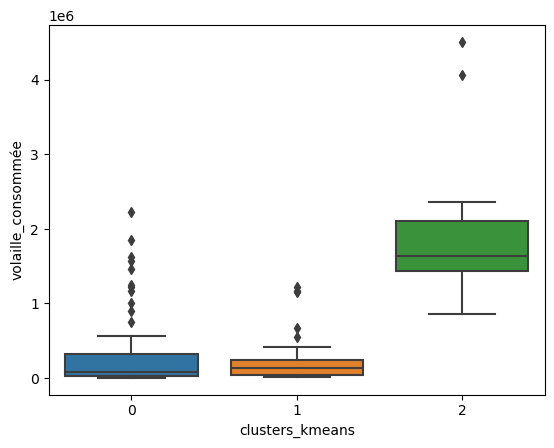

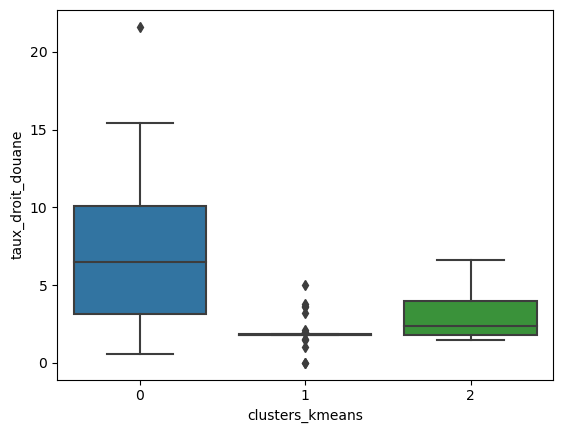

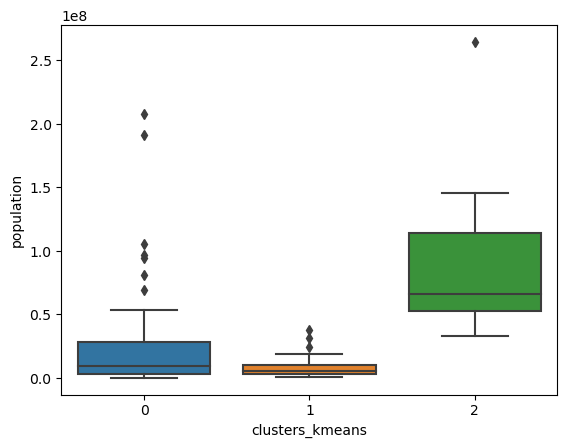

In [344]:
# Distribution des variable pour chaque clusters
print("Distribution des variables pour chaque clusters")

for col in df_final.drop(columns='clusters_kmeans'):
    sns.boxplot(data=df_final, y=col, x='clusters_kmeans')
    plt.show()

On peut déjà rejeter les pays du clusters 0 pour l'implantation du nouveau marché.  
Nous allons voir les points forts et les points faibles des clusters 1 et 2.

 - Les pays du cluster 2 possèdent un marché plus important du fait de leur taille (population, pib, volaille consommée (tonnes), importation volaille (tonnes). 

- En ce qui concerne le pib par habitant, le lpi et le taux de population urbaine, les clusters 1 et 2 sont similaires.

- Le cluster 1 a un taux de dépendance plus important et une stabilité politique légèrement plus importante et des taux de droit de douane plus faible. 


Globalement ces graphiques montrent que les pays du clusters 2 sont plus intéressant si on veut s'introduire sur un gros marché, dans un grand pays ou il y a beaucoup de demandes.  
Mais certains pays du cluster 1 peuvent être une très bonne solution, si on veut se placer sur un pays plus petit mais très dépendant de ses importations en volaille.

### Pays Clusters 1

In [345]:
df_final[df_final['clusters_kmeans'] == 1]

,clusters_kmeans,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
pays,,,,,,,,,,,
Australie,1,"53,957.16","16,000.00",0.01,3.77,"1,326,516,328,531.56",0.89,0.85,"1,171,000.00",1.49,"24,584,620.00"
Autriche,1,"47,309.05","110,000.00",0.64,3.90,"417,261,151,844.98",1.05,0.58,"160,000.00",1.81,"8,819,901.00"
Belgique,1,"44,025.90","338,000.00",2.22,4.02,"502,764,720,556.35",0.43,0.98,"144,000.00",1.81,"11,419,748.00"
Botswana,1,"7,303.67","3,000.00",0.43,2.76,"16,105,182,316.33",1.02,0.71,"7,000.00",1.03,"2,205,080.00"
Bulgarie,1,"8,335.08","108,000.00",0.69,3.04,"59,199,447,421.49",0.33,0.74,"157,000.00",1.81,"7,102,444.00"
Chili,1,"14,962.55","155,000.00",0.23,3.18,"276,364,933,679.63",0.42,0.86,"672,000.00",2.01,"18,470,439.00"
Chine - RAS de Hong-Kong,1,"46,709.31","907,000.00",3.24,3.97,"341,273,289,534.47",0.83,1.01,"391,000.00",0.00,"7,306,322.00"
Chine - RAS de Macao,1,"81,018.56","23,000.00",1.21,3.58,"50,440,941,938.70",1.43,1.00,"21,000.00",0.00,"622,585.00"
Chypre,1,"19,451.69","14,000.00",0.37,3.12,"22,946,726,163.58",0.54,0.67,"30,000.00",1.81,"1,179,678.00"


### Pays Clusters 2

In [346]:
df_final[df_final['clusters_kmeans'] == 2]

,clusters_kmeans,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
pays,,,,,,,,,,,
Afrique du Sud,2,"6,690.94","514,000.00",0.24,3.57,"381,448,814,653.46",-0.28,0.66,"2,035,000.00",4.44,"57,009,756.00"
Allemagne,2,"44,651.83","842,000.00",0.48,4.13,"3,690,849,152,517.65",0.59,0.77,"1,609,000.00",1.81,"82,658,409.00"
Arabie saoudite,2,"20,802.46","722,000.00",0.50,3.19,"688,586,094,412.68",-0.58,0.83,"1,435,000.00",4.03,"33,101,179.00"
Canada,2,"44,899.85","182,000.00",0.13,3.87,"1,649,265,644,244.09",1.10,0.81,"1,433,000.00",1.48,"36,732,095.00"
Espagne,2,"28,152.58","205,000.00",0.14,3.75,"1,313,245,330,197.65",0.28,0.80,"1,418,000.00",1.81,"46,647,428.00"
France,2,"40,022.37","506,000.00",0.32,3.86,"2,595,151,045,197.65",0.28,0.80,"1,485,000.00",1.81,"64,842,509.00"
Fédération de Russie,2,"10,817.00","226,000.00",0.05,2.64,"1,574,199,387,070.90",-0.64,0.74,"4,509,000.00",4.92,"145,530,082.00"
Indonésie,2,"3,837.58","1,000.00",0.00,2.99,"1,015,618,742,565.81",-0.50,0.55,"1,904,000.00",2.31,"264,650,963.00"
Italie,2,"32,333.55","97,000.00",0.08,3.70,"1,961,796,197,354.36",0.31,0.69,"1,146,000.00",1.81,"60,673,701.00"


### Proposition de pays

In [347]:
df_projection['clusters_kmeans'] = clusters_kmeans

Voici les conditions minimum pour la sélection de pays :
- Indice 'Développement, Richesse et Qualité de vie' fort > 2, indice le plus important et contenant le plus d'informations, garantie que le pays est développé et que ses habitants possède un niveau de vie suffisant.
- Indice 'Taille du Pays et du Marché' > -2, pour rejeter les plus petits pays ou/et ceux qui ne consomment pas beaucoup de volailles.
- Indice 'Besoin en Volaille' > 1, pour garder les pays où il y a de la demande en volaille parce qu'ils consomment et qu'ils sont dépendants des importations.

#### Cluster 2 

In [271]:
# sélection des pays dans le clusters 2
mask = (df_projection['F1']>2)&(df_projection['F2']>0)&(df_projection['F3']>0)&(df_projection['clusters_kmeans']==2)

In [349]:
# je retire la France de la proposition
preselection2 = df_projection[mask].drop('France')
preselection2

,F1,F2,F3,clusters_kmeans
Allemagne,5.77,2.60,1.33,2
Arabie saoudite,2.11,1.49,1.38,2
Japon,7.26,4.25,1.88,2
Mexique,3.45,5.19,1.49,2
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,4.97,2.50,0.94,2


In [353]:
# on rajoute toutes les colonnes pour comparer la présélection
df_final2 = df.set_index('pays').drop(columns=['clusters_cah', 'clusters_kmeans'])

preselection2_all = df_final2.loc[list(preselection2.index)]
preselection2_all

,exportation_volaille,importation_volaille,production,volaille_consommée,taux_dependance,taux_autosuffisance,proportion_volaille_nourriture,proportion_animaux_nourriture,population,accroissement_population_moyen_par_annee,taux_accroissement_population_moyen,lpi,pib,taux_droit_douane,quantite_conteneurs_par_annee,taux_population_urbaine,stabilite_politique,pib_par_habitant,classement_consommation
pays,,,,,,,,,,,,,,,,,,,
Allemagne,"646,000.00","842,000.00","1,514,000.00","1,609,000.00",0.48,0.50,0.02,0.10,"82,658,409.00","90,712.42",0.00,4.13,"3,690,849,152,517.65",1.81,"15,169,595.00",0.77,0.59,"44,651.83",15.00
Arabie saoudite,"10,000.00","722,000.00","616,000.00","1,435,000.00",0.50,0.42,0.08,0.12,"33,101,179.00","686,258.58",0.02,3.19,"688,586,094,412.68",4.03,"8,082,329.00",0.83,-0.58,"20,802.46",19.00
Japon,"10,000.00","1,069,000.00","2,215,000.00","2,359,000.00",0.44,0.91,0.03,0.16,"127,502,725.00","-16,946.42",-0.00,3.95,"4,930,837,369,151.42",2.35,"22,795,035.00",0.92,1.11,"38,672.41",7.00
Mexique,"9,000.00","972,000.00","3,249,000.00","4,058,000.00",0.23,0.77,0.04,0.11,"124,777,324.00","1,436,365.42",0.01,3.05,"1,158,913,035,796.37",3.67,"6,375,338.00",0.83,-0.72,"9,287.85",5.00
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,"359,000.00","779,000.00","1,814,000.00","2,131,000.00",0.35,0.65,0.04,0.10,"66,727,461.00","432,546.05",0.01,3.94,"2,683,399,006,715.79",2.06,"10,239,966.00",0.82,0.33,"40,214.31",9.00


Voici les pays les plus intéressant si on projette d'intégrer un gros marché (clusters 2).

L'Allemagne et le Royaume-Uni sont particulièrement intéressant grâce à leur proximité géographique, leur taux de droit de douane et leur stabilité politique. Le Japon les rejoint pour les 3 derniers critères.

#### Cluster 1

In [258]:
# sélection des pays dans le clusters 1
mask2 = (df_projection['F1']>2)&(df_projection['F3']>0)&(df_projection['clusters_kmeans']==1)

In [354]:
preselection1 = df_projection[mask2]
preselection1

,F1,F2,F3,clusters_kmeans
Belgique,3.15,-2.15,2.42,1
Chine - RAS de Hong-Kong,4.62,-2.37,5.08,1
Pays-Bas,3.89,-1.44,2.18,1
Émirats arabes unis,2.53,-1.16,1.16,1


In [355]:
preselection1_all = df_final2.loc[list(preselection1.index)]
preselection1_all

,exportation_volaille,importation_volaille,production,volaille_consommée,taux_dependance,taux_autosuffisance,proportion_volaille_nourriture,proportion_animaux_nourriture,population,accroissement_population_moyen_par_annee,taux_accroissement_population_moyen,lpi,pib,taux_droit_douane,quantite_conteneurs_par_annee,taux_population_urbaine,stabilite_politique,pib_par_habitant,classement_consommation
pays,,,,,,,,,,,,,,,,,,,
Belgique,"656,000.00","338,000.00","463,000.00","144,000.00",2.22,-1.27,0.01,0.08,"11,419,748.00","63,165.53",0.01,4.02,"502,764,720,556.35",1.81,"10,783,850.00",0.98,0.43,"44,025.90",70.00
Chine - RAS de Hong-Kong,"663,000.00","907,000.00","24,000.00","391,000.00",3.24,-2.28,0.07,0.30,"7,306,322.00","40,284.37",0.01,3.97,"341,273,289,534.47",0.00,"20,760,000.00",1.01,0.83,"46,709.31",41.00
Pays-Bas,"1,418,000.00","608,000.00","1,100,000.00","346,000.00",1.63,-0.85,0.02,0.09,"17,021,347.00","59,651.16",0.00,4.07,"833,869,641,687.06",1.81,"13,992,474.00",0.91,0.92,"48,989.64",45.00
Émirats arabes unis,"94,000.00","433,000.00","48,000.00","412,000.00",1.05,-0.11,0.07,0.13,"9,487,203.00","341,941.95",0.04,3.81,"390,516,804,016.50",3.64,"19,089,706.00",0.85,0.62,"41,162.48",39.00


Voici des candidats intéressant pour des pays plus petits, en particulier la Belgique et les Pays Bas, pour leur proximité géographique et leur appartenance à l'espace Schengen.

### Conclusion deuxième itération et générale

Cette deuxième itération a permis de classer les pays selon 3 composantes principales et 3 clusters.  

Les 3 composantes principales étaient :
- Développement, Richesse et Qualité de vie
- Taille du Pays et du Marché
- Besoin en Volaille

Le cluster 0 contenait des pays peu développés, avec un niveau de vie trop faible. Il n'était pas adapté pour le nouveau marché.

Le cluster 1 contenait des pays petits ou moyens, développés avec un besoin important en volaille.

Le cluster 2 contenait des grands pays, puissants et développés avec un besoin important en volaille.

Les pays retenus dans le cluster 1 :
- Belgique
- Pays-Bas

Les pays retenus dans le cluster 1 :
- Allemagne
- Royaume-Uni

# Bonus 3e itération avec 5, 6, 10 clusters

In [403]:
# création de l'estimateur

kmeans = KMeans(n_clusters=10, random_state=1)

kmeans.fit(X_scaled)

# coordonnées des centroides

centroides = kmeans.cluster_centers_

# clusters de l'echantillon

clusters_kmeans = kmeans.labels_

In [404]:
df_centroide_kmeans = pd.DataFrame(pca.transform(centroides), columns=['F1', 'F2', 'F3'])
df_centroide_kmeans

,F1,F2,F3
0,-0.18,-0.76,-0.35
1,-0.67,1.71,-0.27
2,5.54,2.79,1.10
3,2.33,-2.18,-0.90
4,-1.99,0.16,-0.03
5,1.87,0.76,-0.68
6,3.55,-1.78,2.71
7,-0.80,4.23,-0.64
8,-1.63,-0.52,1.58
9,2.73,5.27,0.58


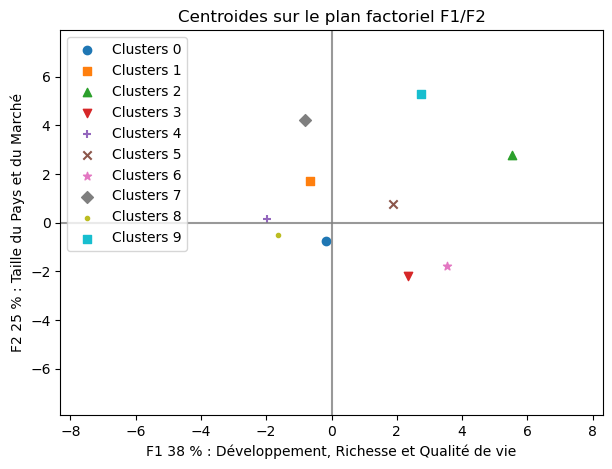

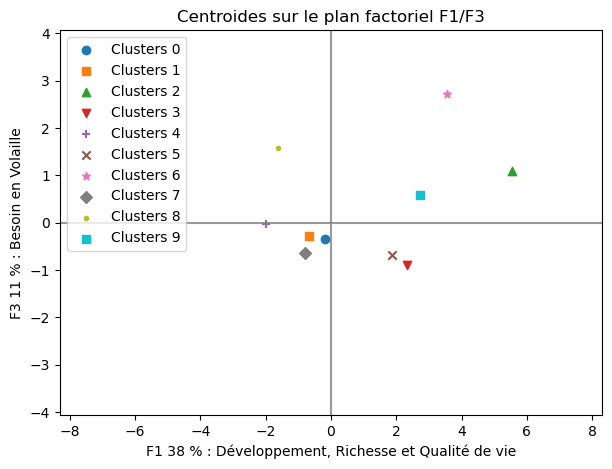

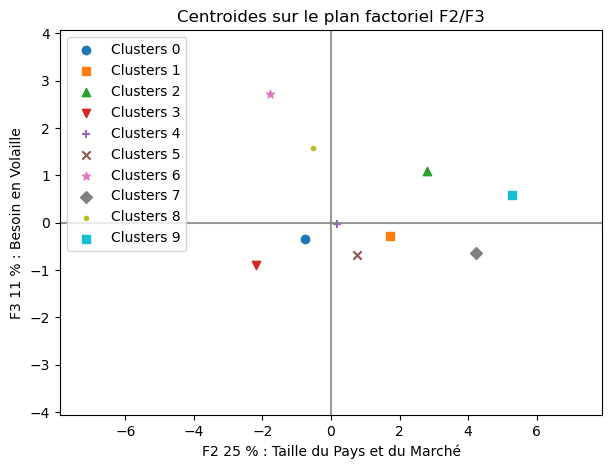

In [405]:
x_y = (0,1)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

x_y = (0,2)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

x_y = (1,2)
projection_centroides(df_centroide_kmeans, resume_composante, x_y, pca=pca)

df_projection['clusters_kmeans'] = clusters_kmeans

Distribution des variables pour chaque clusters


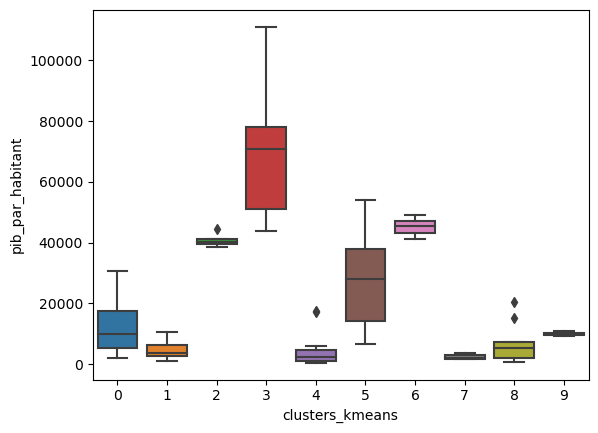

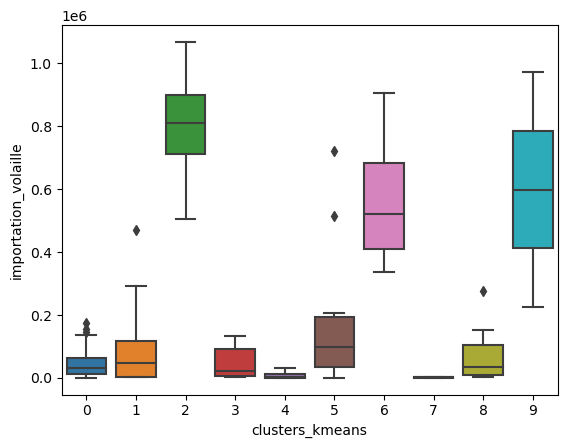

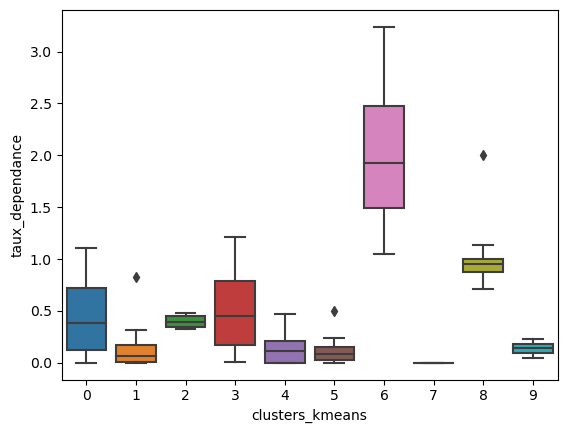

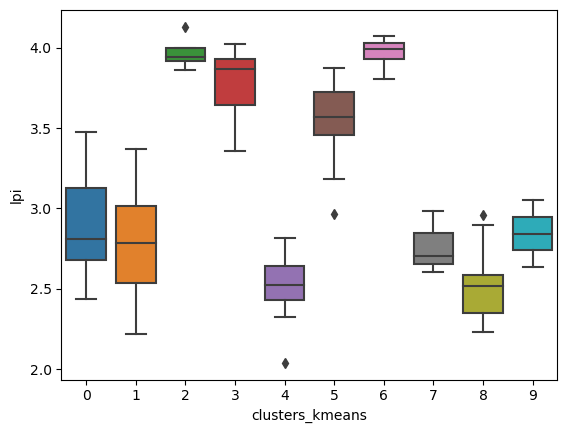

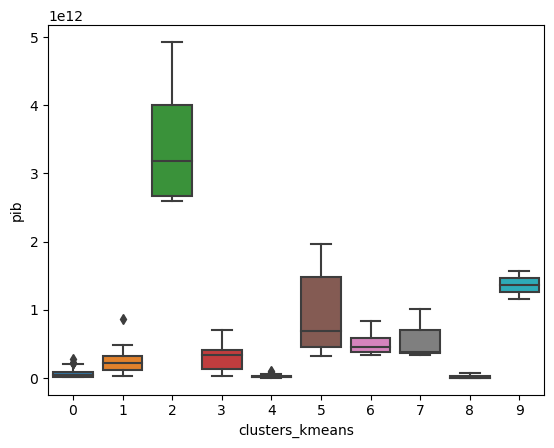

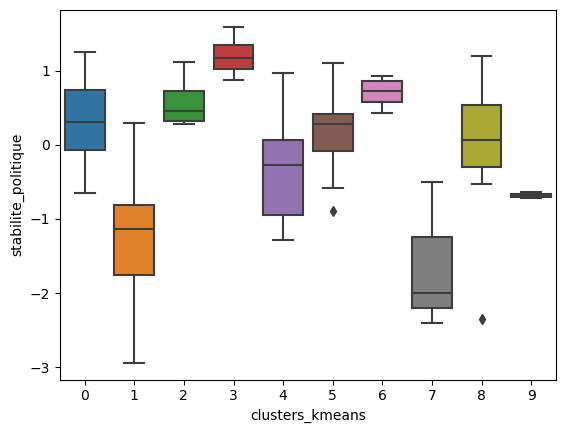

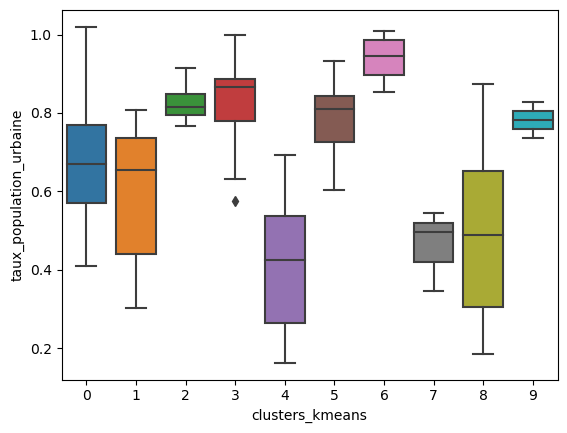

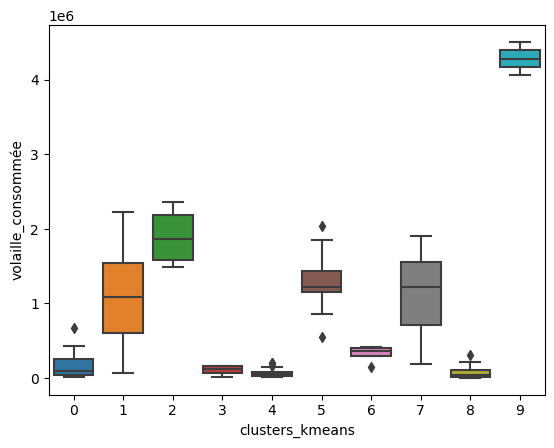

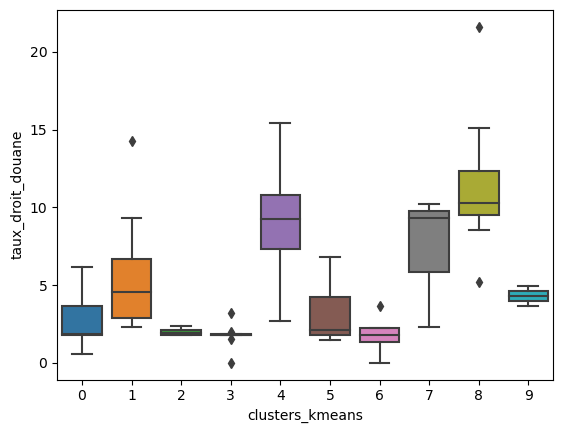

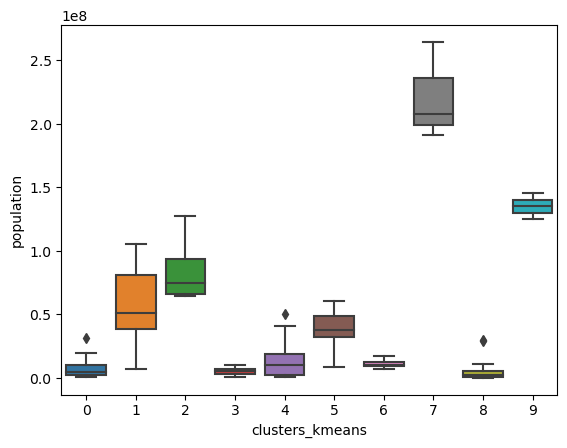

In [392]:
# df analyse finale
col_finale = np.insert(variables, 0, ['pays', 'clusters_kmeans'])
df_final = df[col_finale]
df_final['clusters_kmeans'] = clusters_kmeans
df_final = df_final.set_index('pays')

# Distribution des variable pour chaque clusters
print("Distribution des variables pour chaque clusters")

for col in df_final.drop(columns='clusters_kmeans'):
    sns.boxplot(data=df_final, y=col, x='clusters_kmeans')
    plt.show()

### Visualisation de quelques clusters dans le détail

In [408]:
df_final[df_final['clusters_kmeans']==2]

,clusters_kmeans,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
pays,,,,,,,,,,,
Allemagne,2,"44,651.83","842,000.00",0.48,4.13,"3,690,849,152,517.65",0.59,0.77,"1,609,000.00",1.81,"82,658,409.00"
France,2,"40,022.37","506,000.00",0.32,3.86,"2,595,151,045,197.65",0.28,0.80,"1,485,000.00",1.81,"64,842,509.00"
Japon,2,"38,672.41","1,069,000.00",0.44,3.95,"4,930,837,369,151.42",1.11,0.92,"2,359,000.00",2.35,"127,502,725.00"
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,2,"40,214.31","779,000.00",0.35,3.94,"2,683,399,006,715.79",0.33,0.82,"2,131,000.00",2.06,"66,727,461.00"


On retrouve les pays sélectionnés précédemment :  grands pays développés avec une grosse demande en volaille.

In [409]:
df_final[df_final['clusters_kmeans']==3]

,clusters_kmeans,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
pays,,,,,,,,,,,
Autriche,3,"47,309.05","110,000.00",0.64,3.90,"417,261,151,844.98",1.05,0.58,"160,000.00",1.81,"8,819,901.00"
Chine - RAS de Macao,3,"81,018.56","23,000.00",1.21,3.58,"50,440,941,938.70",1.43,1.00,"21,000.00",0.00,"622,585.00"
Danemark,3,"57,938.80","133,000.00",0.80,3.93,"332,121,063,806.39",0.87,0.88,"166,000.00",1.81,"5,732,274.00"
Finlande,3,"46,385.55","16,000.00",0.14,3.94,"255,647,979,916.47",1.08,0.86,"103,000.00",1.81,"5,511,371.00"
Irlande,3,"70,767.46","99,000.00",0.77,3.70,"336,377,500,160.55",1.00,0.63,"123,000.00",1.81,"4,753,279.00"
Islande,3,"73,949.77","2,000.00",0.20,3.36,"24,728,285,177.46",1.35,0.94,"10,000.00",1.53,"334,393.00"
Luxembourg,3,"111,017.18","11,000.00",1.00,3.87,"65,712,180,342.98",1.33,0.89,"11,000.00",1.81,"591,910.00"
Norvège,3,"75,220.81","2,000.00",0.02,3.78,"398,393,955,268.99",1.17,0.82,"101,000.00",3.22,"5,296,326.00"
Nouvelle-Zélande,3,"43,943.48","1,000.00",0.01,3.60,"206,623,758,800.16",1.59,0.87,"164,000.00",1.83,"4,702,034.00"


Ici, petits pays développés, avec une demande moyenne en volaille globalement, moyennement dépendant de l'importation globalement.

In [417]:
df_final[df_final['clusters_kmeans']==6]

,clusters_kmeans,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
pays,,,,,,,,,,,
Belgique,6,"44,025.90","338,000.00",2.22,4.02,"502,764,720,556.35",0.43,0.98,"144,000.00",1.81,"11,419,748.00"
Chine - RAS de Hong-Kong,6,"46,709.31","907,000.00",3.24,3.97,"341,273,289,534.47",0.83,1.01,"391,000.00",0.00,"7,306,322.00"
Pays-Bas,6,"48,989.64","608,000.00",1.63,4.07,"833,869,641,687.06",0.92,0.91,"346,000.00",1.81,"17,021,347.00"
Émirats arabes unis,6,"41,162.48","433,000.00",1.05,3.81,"390,516,804,016.50",0.62,0.85,"412,000.00",3.64,"9,487,203.00"


Ici, petits pays développés, avec une grosse demande en volaille, très dépendant de l'importation.

In [424]:
df_final[df_final['clusters_kmeans']==5]

,clusters_kmeans,pib_par_habitant,importation_volaille,taux_dependance,lpi,pib,stabilite_politique,taux_population_urbaine,volaille_consommée,taux_droit_douane,population
pays,,,,,,,,,,,
Afrique du Sud,5,"6,690.94","514,000.00",0.24,3.57,"381,448,814,653.46",-0.28,0.66,"2,035,000.00",4.44,"57,009,756.00"
Arabie saoudite,5,"20,802.46","722,000.00",0.50,3.19,"688,586,094,412.68",-0.58,0.83,"1,435,000.00",4.03,"33,101,179.00"
Argentine,5,"14,648.85","8,000.00",0.00,2.96,"643,628,665,302.15",0.17,0.92,"1,856,000.00",6.81,"43,937,140.00"
Australie,5,"53,957.16","16,000.00",0.01,3.77,"1,326,516,328,531.56",0.89,0.85,"1,171,000.00",1.49,"24,584,620.00"
Canada,5,"44,899.85","182,000.00",0.13,3.87,"1,649,265,644,244.09",1.10,0.81,"1,433,000.00",1.48,"36,732,095.00"
Espagne,5,"28,152.58","205,000.00",0.14,3.75,"1,313,245,330,197.65",0.28,0.80,"1,418,000.00",1.81,"46,647,428.00"
Israël,5,"43,456.09",0.00,0.00,3.45,"358,245,427,458.54",-0.89,0.93,"556,000.00",2.09,"8,243,848.00"
Italie,5,"32,333.55","97,000.00",0.08,3.70,"1,961,796,197,354.36",0.31,0.69,"1,146,000.00",1.81,"60,673,701.00"
Malaisie,5,"10,259.31","68,000.00",0.04,3.46,"319,112,175,611.57",0.12,0.77,"1,220,000.00",3.58,"31,104,646.00"


Ici, gros pays, bien développés globalement. Mais autosuffisant en volaille.

### Export Tableau

In [423]:
col_test_clusters = np.insert(variables, 0, 'pays')

df_test_clusters = df[col_test_clusters]

df_test_clusters['clusters'] = clusters_kmeans
df_test_clusters['clusters'] = df_test_clusters['clusters'].astype('str')


df_test_clusters['F1'] = df_projection['F1'].values
df_test_clusters['F2'] = df_projection['F2'].values
df_test_clusters['F3'] = df_projection['F3'].values


df_test_clusters.to_csv(folder+'export_tableau.csv', index=False)